<a href="https://www.kaggle.com/code/anugrahgupta/regression-problem-2-predicting-accidents?scriptVersionId=272713777" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session



import warnings
warnings.filterwarnings('ignore')

/kaggle/input/playground-series-s5e10/sample_submission.csv
/kaggle/input/playground-series-s5e10/train.csv
/kaggle/input/playground-series-s5e10/test.csv


# 🚦 Road Accident Risk Prediction – First Steps Checklist

## 1. Problem Statement
- [x] Write a one-line project goal  
- [ ] Choose **primary metric** (e.g., Accuracy, ROC-AUC, F1-score)

---

## 2. Data Audit
- [ ] Compute dataset shape (rows × columns)  
- [ ] Check duplicates (% of rows)  
- [ ] Count unique values for Road Type, Curvature, Weather, Time of Day  

---

## 3. Target Variable (Accident Risk)
- [ ] Analyze distribution: #Accident (0/1 or risk score)  
- [ ] Check class imbalance (% accident vs. no accident)  
- [ ] Calculate summary stats if continuous risk (mean, std, min, max, skewness)

---

## 4. Feature Sanity Checks
- [ ] Speed Limit: check distribution, plausible range  
- [ ] Number of Lanes: check range, spot suspicious values  
- [ ] Curvature: check for valid categories/values  
- [ ] Lighting, Weather: check for rare/unexpected values

---

## 5. Visual EDA
- [ ] Histogram/Barplot: Accident vs. Non-Accident cases  
- [ ] Barplot: Accident rate by Road Type  
- [ ] Boxplot: Speed Limit by Accident occurrence  
- [ ] Plot: Accidents by Time of Day

---

## 6. Missingness & Categories
- [ ] Record % missing per column  
- [ ] List top 10 Road Types, Curvature classes, Weather types by frequency  

---

## 7. Feature Engineering
- [ ] Create derived features (e.g., IsNight = lighting, RushHour = time_of_day)  
- [ ] Group similar weather/curvature categories as needed  

---

## 8. Train/Test Setup
- [ ] Split data → hold out 10–20% as final test set  

---

## 9. Baseline Model
- [ ] Fit baseline: predict majority class or mean risk  
- [ ] Fit baseline: group baseline (e.g., by Road Type, Time of Day)  
- [ ] Record primary metric for both baselines


 ## 10. Evaluation of the Model

 - [ ] Check the model against metrics
 - [ ] Visualise the predicted values of the model against the actual values
 - [ ] Check the score of RMSE/MAE
 - [ ] Check how much better model is working for higher values of accident risks compared to lowerer values of the accidents(class imbalance)
       


# Problem Statement: 

We want to build a predictive model that estimates the risk of Accident on a particular road on it's charactersticsr(oad_type, num_lanes,curvature, speed_limit, lighting, weather,road_signs_present, public_road, time_of_day)




## **Objective**

The goal is:
    1. to analyse the Predicting Road Accident Risk dataset to find the hidden insights about roads and accidents caused. 
    2. To Predict the Accident risk given the specifics character of a road.
    3. Make sure the model is generalized well and is not biased irregularly.



## Stakeholders & Use Case?

**Drivers:** Any one would likes to travel

**Government:** Government should understand and be aware about different types of roads and how they can affect the public and plan the development accordingly.

**Road Engineers/Maintainance staff** Road Engineers/Maintainance staff should be aware about different aspects of a road and how they increase or reduces the chances of accidents.


## Success Metrics(s) --:  
**Primary Metrics:**  
1. **MAE:** Mean Absolute Error(Less than 10%)

**Secondary**: 
1. **$R^2$**: Explained Variance.



## BaseLine: 
Mean Price



# Utilities

In [2]:
import matplotlib.pyplot as plt

def plot_categorical_bar(df, column, top_n=None, figsize=(8,5), color='#4287f5', show_percent=False, sort='value'):
    """
    Plots a bar chart for a categorical column in a DataFrame,
    optionally annotating bars with percentages and custom sorting.

    Parameters:
        df (pd.DataFrame): Data frame.
        column (str): Column to plot.
        top_n (int, optional): Show top N categories only.
        figsize (tuple, optional): Size of figure.
        color (str, optional): Bar color.
        show_percent (bool, optional): Annotate bars with percentages.
        sort (str, optional): 'frequency' (default) or 'value'

    Returns:
        matplotlib.axes.Axes: Plotted axes.
    """
    counts = df[column].value_counts()
    if sort == 'value':
        counts = counts.sort_index()
    elif sort == 'frequency':
        counts = counts.sort_values(ascending=False)
    if top_n is not None:
        counts = counts.head(top_n)
    percent = counts / counts.sum() * 100

    ax = counts.plot(kind='bar', figsize=figsize, color=color)
    ax.set_xlabel(column)
    ax.set_ylabel('Count')
    ax.set_title(f'Distribution of {column}')
    plt.xticks(rotation=45)

    if show_percent:
        for i, p in enumerate(ax.patches):
            ax.annotate(f'{percent.iloc[i]:.1f}%', 
                        (p.get_x() + p.get_width()/2, p.get_height()), 
                        ha='center', va='bottom', fontsize=11, color='black')

    plt.tight_layout()
    plt.show()
    return ax



def plot_numerical_hist(df, column, bins=10, figsize=(8,5), color='#4287f5', show_percent=False):
    """
    Plots a histogram showing the distribution of values for a numerical column in a DataFrame,
    optionally annotating bars with percentages.

    Parameters:
        df (pd.DataFrame): The data frame containing the data.
        column (str): Column to plot.
        bins (int or list, optional): Number of bins or bin edges.
        figsize (tuple, optional): Size of figure.
        color (str, optional): Bar color.
        show_percent (bool, optional): Annotate bars with percentages if True.

    Returns:
        matplotlib.axes.Axes: The plotted axes.
    """
    data = df[column].dropna()

    fig, ax = plt.subplots(figsize=figsize)
    counts, bin_edges, patches = ax.hist(data, bins=bins, color=color, edgecolor='black', alpha=0.8)
    ax.set_xlabel(column)
    ax.set_ylabel('Count')
    ax.set_title(f'Distribution of {column}')
    plt.xticks(rotation=45)

    if show_percent:
        total = len(data)
        for count, patch in zip(counts, patches):
            if count > 0:
                # Place annotation at center top of each bar
                x = patch.get_x() + patch.get_width() / 2
                percent = 100 * count / total
                ax.annotate(f'{percent:.1f}%', (x, count), ha='center', va='bottom', fontsize=11, color='black')

    plt.tight_layout()
    plt.show()
    return ax



def plot_bivariate_bar(df, cat_col, target_col, top_n=None, figsize=(8,5), color='#4287f5', sort='value', show_count=False):
    """
    Plots a bar chart of the mean target value for each category in a categorical column.
    
    Parameters:
        df (pd.DataFrame): Data frame.
        cat_col (str): Categorical column.
        target_col (str): Target column (numerical).
        top_n (int, optional): Show top N categories only.
        figsize (tuple, optional): Size of figure.
        color (str, optional): Bar color.
        sort (str, optional): 'value' (alphabetical/category index) or 'mean' (target mean) or 'count' (category frequency).
        show_count (bool, optional): Show count of each category above bars.
        
    Returns:
        matplotlib.axes.Axes: Plotted axes.
    """
    gp = df.groupby(cat_col)[target_col].mean()
    cnt = df[cat_col].value_counts()
    
    # Optionally sort
    if sort == 'value':
        gp = gp.sort_index()
    elif sort == 'mean':
        gp = gp.sort_values(ascending=False)
    elif sort == 'count':
        gp = gp[cnt.loc[gp.index].sort_values(ascending=False).index]
    
    if top_n is not None:
        gp = gp.head(top_n)

    ax = gp.plot(kind='bar', figsize=figsize, color=color)
    ax.set_xlabel(cat_col)
    ax.set_ylabel(f'Mean {target_col}')
    ax.set_title(f'{target_col} by {cat_col}')
    plt.xticks(rotation=45)
    
    if show_count:
        counts_subset = cnt.loc[gp.index]
        for i, p in enumerate(ax.patches):
            ax.annotate(f'n={counts_subset.iloc[i]}',
                        (p.get_x() + p.get_width()/2, p.get_height()),
                        ha='center', va='bottom', fontsize=11, color='black')
    
    plt.tight_layout()
    plt.show()
    return ax

import matplotlib.pyplot as plt

def plot_scatter(df, x_col, y_col, figsize=(8,5), color='#4287f5', alpha=0.6, add_regline=False, title=None):
    """
    Plots a scatter plot for two numerical columns in a DataFrame.

    Parameters:
        df (pd.DataFrame): Data frame.
        x_col (str): Column name for x-axis (numerical).
        y_col (str): Column name for y-axis (numerical).
        figsize (tuple, optional): Size of figure.
        color (str, optional): Point color.
        alpha (float, optional): Point transparency.
        add_regline (bool, optional): Overlay a regression line.
        title (str, optional): Custom plot title.

    Returns:
        matplotlib.axes.Axes: Plotted axes.
    """
    fig, ax = plt.subplots(figsize=figsize)
    ax.scatter(df[x_col], df[y_col], color=color, alpha=alpha)
    ax.set_xlabel(x_col)
    ax.set_ylabel(y_col)
    ax.set_title(title or f'{y_col} vs {x_col}')
    
    # Optionally add regression line
    if add_regline:
        import numpy as np
        from sklearn.linear_model import LinearRegression
        # Drop missing values for both columns
        X = df[[x_col, y_col]].dropna()
        x = X[x_col].values.reshape(-1, 1)
        y = X[y_col].values
        lr = LinearRegression()
        lr.fit(x, y)
        y_pred = lr.predict(x)
        ax.plot(x, y_pred, color='red', linewidth=2, label='Regression line')
        ax.legend()
    
    plt.tight_layout()
    plt.show()
    return ax



def assign_bins(df, column, bins=5, labels=None, method='quantile', new_col=None, include_lowest=True):
    """
    Assigns bins to a numerical column and adds a new binned column to the DataFrame.

    Parameters:
        df (pd.DataFrame): DataFrame to modify.
        column (str): Name of the numerical column to bin.
        bins (int or list): Number of bins or explicit bin edges.
        labels (list, optional): Labels for the bins. If None, auto-label.
        method (str): 'quantile' (equal-frequency, pd.qcut) or 'uniform' (equal-width, pd.cut)
        new_col (str, optional): Name for the new binned column. Default: column+'_bin'
        include_lowest (bool): Include the lowest value in first bin.

    Returns:
        pd.Series: The newly created binned column.
    """
    if new_col is None:
        new_col = f"{column}_bin"

    col_data = df[column]

    if method == 'quantile':
        # Equal-frequency bins using pd.qcut
        binned = pd.qcut(col_data, q=bins, labels=labels, duplicates='drop', include_lowest=include_lowest)
    else:
        # Equal-width bins using pd.cut
        binned = pd.cut(col_data, bins=bins, labels=labels, include_lowest=include_lowest)
        
    df[new_col] = binned
    return binned

# Example usage:
# assign_bins(df, 'accident_risk', bins=4, method='quantile')
# assign_bins(df, 'num_lanes', bins=[0,2,4,6,8], labels=['1-2','3-4','5-6','7-8'], method='uniform')


from scipy.stats import chi2_contingency

def get_chi2(df, row_col, col_col):
    """
    Computes and prints the chi-square statistic and p-value for two categorical columns.
    """
    table = pd.crosstab(df[row_col], df[col_col])
    chi2, p, dof, expected = chi2_contingency(table)
    print(f"Chi2: {chi2:.6f}, p-value: {p:.6f}")
    return chi2, p
    

import seaborn as sns
import matplotlib.pyplot as plt

def plot_crosstab_heatmap(df, row_col, col_col, normalize='row', cmap='coolwarm', fmt='.2f', figsize=(7,5)):
    """
    Plots a heatmap of normalized proportions for two categorical columns.
    """
    table = pd.crosstab(df[row_col], df[col_col])

    if normalize == 'row':
        proportions = table.div(table.sum(axis=1), axis=0)
    elif normalize == 'column':
        proportions = table.div(table.sum(axis=0), axis=1)
    else:
        proportions = table

    plt.figure(figsize=figsize)
    sns.heatmap(proportions, annot=True, fmt=fmt, cmap=cmap, cbar=True)
    plt.title(f'Proportion of {col_col} within {row_col}')
    plt.ylabel(row_col)
    plt.xlabel(col_col)
    plt.tight_layout()
    plt.show()


## Data Dictionary – Road Accident Risk Dataset

| Column                 | Description                                                        | Type         | Example/Values                       |
|------------------------|--------------------------------------------------------------------|--------------|--------------------------------------|
| road_type              | Type of road segment                                               | Categorical  | 'highway', 'urban', 'rural'          |
| num_lanes              | Number of lanes on the road segment                                | Numerical    | 2, 3, 4                              |
| curvature              | Measure of road curvature (0.0 = straight, 1.0 = highly curved)    | Numerical    | 0.0, 0.7, 1.0                        |
| speed_limit            | Legal speed limit (miles per hour)                                 | Numerical    | 30, 45, 60                           |
| lighting               | Lighting conditions                                                | Categorical  | 'daylight', 'night', 'dim'           |
| weather                | Weather condition at the time                                      | Categorical  | 'clear', 'rainy', 'foggy'            |
| road_signs_present     | Road signs present on the road segment                             | Boolean      | True, False                          |
| public_road            | Is this road segment public or private                             | Boolean      | True, False                          |
| time_of_day            | Time period of the record                                          | Categorical  | 'morning', 'afternoon', 'night'      |
| holiday                | Was the record on a public holiday                                 | Boolean      | True, False                          |
| school_season          | Was the record within an active school period                      | Boolean      | True, False                          |
| num_reported_accidents | Number of past reported accidents on the road segment              | Numerical    | 0, 2, 15                             |
| accident_risk          | Model-generated risk score (0.0 = low risk, 1.0 = high risk)       | Numerical    | 0.05, 0.71, 0.98                     |


# 2. Data Audit
- [x] Loading the dataset
- [x] Compute dataset shape (rows × columns)  
- [ ] Check duplicates (% of rows)  
- [ ] Count unique values for Road Type, Curvature, Weather, Time of Day  


In [3]:
# loading the dataset

df = pd.read_csv("/kaggle/input/playground-series-s5e10/train.csv")
df.head()

id road_type  num_lanes  curvature  speed_limit  lighting weather  \
0   0     urban          2       0.06           35  daylight   rainy   
1   1     urban          4       0.99           35  daylight   clear   
2   2     rural          4       0.63           70       dim   clear   
3   3   highway          4       0.07           35       dim   rainy   
4   4     rural          1       0.58           60  daylight   foggy   

   road_signs_present  public_road time_of_day  holiday  school_season  \
0               False         True   afternoon    False           True   
1                True        False     evening     True           True   
2               False         True     morning     True          False   
3                True         True     morning    False          False   
4               False        False     evening     True          False   

   num_reported_accidents  accident_risk  
0                       1           0.13  
1                       0           0.35  
2                       2           0.30  
3                       1           0.21  
4                       1           0.56

In [4]:
df.head()

id road_type  num_lanes  curvature  speed_limit  lighting weather  \
0   0     urban          2       0.06           35  daylight   rainy   
1   1     urban          4       0.99           35  daylight   clear   
2   2     rural          4       0.63           70       dim   clear   
3   3   highway          4       0.07           35       dim   rainy   
4   4     rural          1       0.58           60  daylight   foggy   

   road_signs_present  public_road time_of_day  holiday  school_season  \
0               False         True   afternoon    False           True   
1                True        False     evening     True           True   
2               False         True     morning     True          False   
3                True         True     morning    False          False   
4               False        False     evening     True          False   

   num_reported_accidents  accident_risk  
0                       1           0.13  
1                       0           0.35  
2                       2           0.30  
3                       1           0.21  
4                       1           0.56

In [5]:
df.shape

(517754, 14)

In [6]:
df.dtypes

id                          int64
road_type                  object
num_lanes                   int64
curvature                 float64
speed_limit                 int64
lighting                   object
weather                    object
road_signs_present           bool
public_road                  bool
time_of_day                object
holiday                      bool
school_season                bool
num_reported_accidents      int64
accident_risk             float64
dtype: object

In [7]:
df.describe()

id      num_lanes      curvature    speed_limit  \
count  517754.000000  517754.000000  517754.000000  517754.000000   
mean   258876.500000       2.491511       0.488719      46.112575   
std    149462.849974       1.120434       0.272563      15.788521   
min         0.000000       1.000000       0.000000      25.000000   
25%    129438.250000       1.000000       0.260000      35.000000   
50%    258876.500000       2.000000       0.510000      45.000000   
75%    388314.750000       3.000000       0.710000      60.000000   
max    517753.000000       4.000000       1.000000      70.000000   

       num_reported_accidents  accident_risk  
count           517754.000000  517754.000000  
mean                 1.187970       0.352377  
std                  0.895961       0.166417  
min                  0.000000       0.000000  
25%                  1.000000       0.230000  
50%                  1.000000       0.340000  
75%                  2.000000       0.460000  
max                  7.000000       1.000000

In [8]:
# Check for duplicate rows in a DataFrame
duplicate_rows = df.duplicated()

# Count total duplicates
num_duplicates = duplicate_rows.sum()
print(f'Total duplicate rows: {num_duplicates}')

# View all duplicate rows (excluding their first occurrence)
duplicates_df = df[duplicate_rows]
print(duplicates_df)

Total duplicate rows: 0
Empty DataFrame
Columns: [id, road_type, num_lanes, curvature, speed_limit, lighting, weather, road_signs_present, public_road, time_of_day, holiday, school_season, num_reported_accidents, accident_risk]
Index: []


In [9]:
# Count of null (missing) values for every column in a DataFrame
null_counts = df.isnull().sum()

print(null_counts)


id                        0
road_type                 0
num_lanes                 0
curvature                 0
speed_limit               0
lighting                  0
weather                   0
road_signs_present        0
public_road               0
time_of_day               0
holiday                   0
school_season             0
num_reported_accidents    0
accident_risk             0
dtype: int64


In [10]:
# For unique values in categorical columns
categorical_cols = df.select_dtypes(include=['object', 'category', 'bool']).columns
for col in categorical_cols:
    unique_vals = df[col].unique()
    print(f"Unique values in '{col}': {unique_vals}")


# For mean and std in numerical columns
numerical_cols = df.select_dtypes(include=['number']).columns
for col in numerical_cols:
    mean_val = df[col].mean()
    std_val = df[col].std()
    print(f"Mean and STD of '{col}': Mean = {mean_val}, Std = {std_val}")

Unique values in 'road_type': ['urban' 'rural' 'highway']
Unique values in 'lighting': ['daylight' 'dim' 'night']
Unique values in 'weather': ['rainy' 'clear' 'foggy']
Unique values in 'road_signs_present': [False  True]
Unique values in 'public_road': [ True False]
Unique values in 'time_of_day': ['afternoon' 'evening' 'morning']
Unique values in 'holiday': [False  True]
Unique values in 'school_season': [ True False]
Mean and STD of 'id': Mean = 258876.5, Std = 149462.84997372743
Mean and STD of 'num_lanes': Mean = 2.4915114127558646, Std = 1.1204343388866453
Mean and STD of 'curvature': Mean = 0.4887191965740487, Std = 0.2725632502134713
Mean and STD of 'speed_limit': Mean = 46.112574697636326, Std = 15.788520583305775
Mean and STD of 'num_reported_accidents': Mean = 1.187969576285263, Std = 0.89596123322755
Mean and STD of 'accident_risk': Mean = 0.3523774031683, Std = 0.16641713134848946


### **Observation**:
1. There are no duplicates
2. Total 5 lakhs+ records.
3. No Null values for any column
   

# Target Variable Analysis

- [ ] Analyze distribution: #Accident (0/1 or risk score)  
- [ ] Check class imbalance (% accident vs. no accident)  
- [ ] Calculate summary stats if continuous risk (mean, std, min, max, skewness)

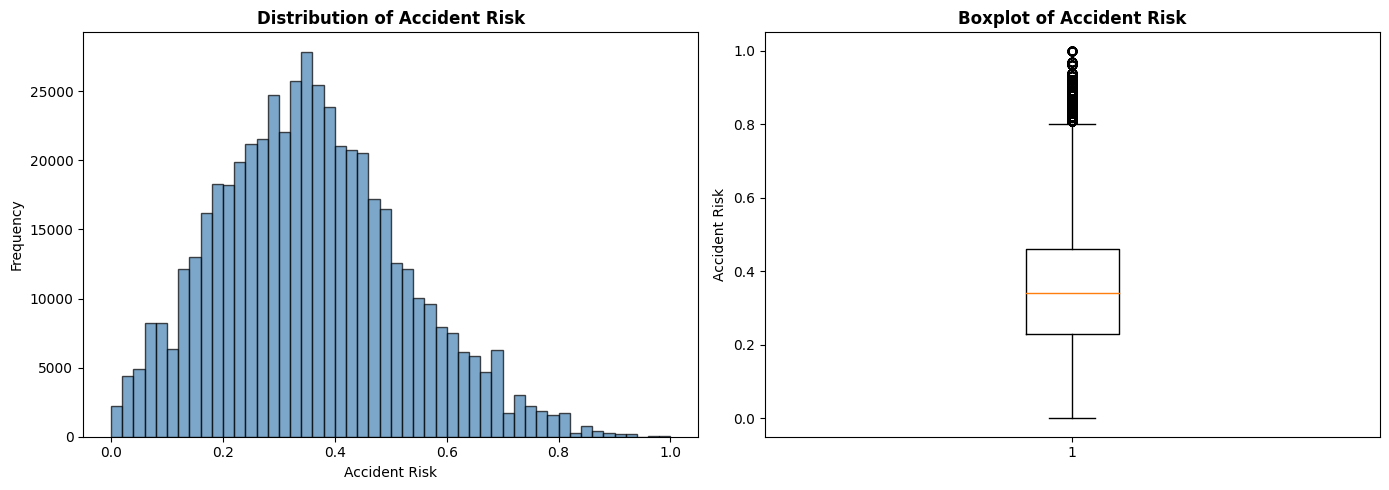

Target Variable Statistics:
count    517754.000000
mean          0.352377
std           0.166417
min           0.000000
25%           0.230000
50%           0.340000
75%           0.460000
max           1.000000
Name: accident_risk, dtype: float64


In [11]:
# Visualize target variable distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].hist(df['accident_risk'], bins=50, edgecolor='black', alpha=0.7, color='steelblue')
axes[0].set_title('Distribution of Accident Risk', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Accident Risk')
axes[0].set_ylabel('Frequency')

axes[1].boxplot(df['accident_risk'])
axes[1].set_title('Boxplot of Accident Risk', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Accident Risk')

plt.tight_layout()
plt.show()

print(f'Target Variable Statistics:')
print(df['accident_risk'].describe())

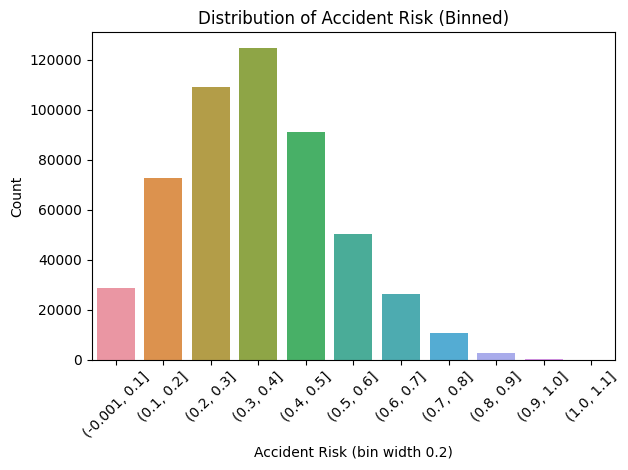

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Create bins for accident_risk with width 0.2
bins = np.arange(0, 1.2, 0.1)  # [0.0, 0.2, 0.4, ..., 1.0]
df['risk_bin'] = pd.cut(df['accident_risk'], bins=bins, include_lowest=True)

# Plot count of records in each bin
sns.countplot(x='risk_bin', data=df)
plt.xlabel('Accident Risk (bin width 0.2)')
plt.ylabel('Count')
plt.title('Distribution of Accident Risk (Binned)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


<Axes: xlabel='num_reported_accidents', ylabel='count'>

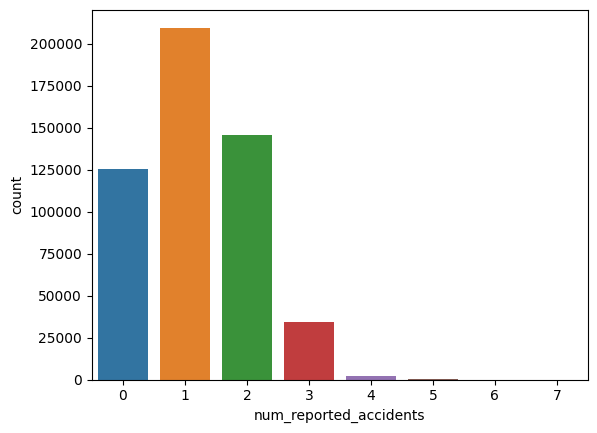

In [13]:
import seaborn as sns
sns.countplot(x='num_reported_accidents', data=df)

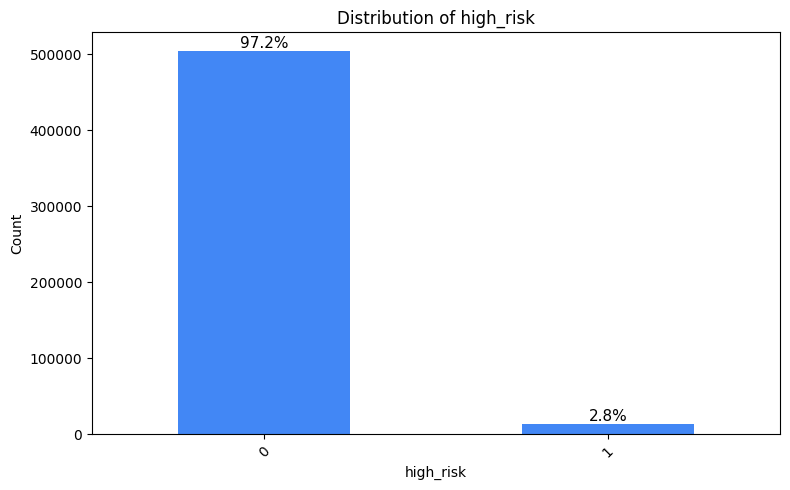

<Axes: title={'center': 'Distribution of high_risk'}, xlabel='high_risk', ylabel='Count'>

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

df['high_risk'] = (df['accident_risk'] > 0.7).astype(int)

plot_categorical_bar(df, 'high_risk', color='#4287f5', show_percent=True)

In [15]:
print(df['accident_risk'].describe())
print('Skewness:', df['accident_risk'].skew())

count    517754.000000
mean          0.352377
std           0.166417
min           0.000000
25%           0.230000
50%           0.340000
75%           0.460000
max           1.000000
Name: accident_risk, dtype: float64
Skewness: 0.37841797634228086


In [16]:
df.drop(['risk_bin', 'high_risk'], axis=1, inplace=True)

### **Observerations**:

1. The distribution looks near normal with a bit right skewed, with median being around 0.3.
2. After closer look from figure The class imbalance is present with where the accident_risk greater than .7(higher) is only in 2.8 % cases. 


### Questions from above observations

1. As we see even the third quartile which composed of 75% of the data is lower than the 0.5, that means that for 75 % of the data the risk of accident is lower than the coint toss. Which is a good thing for general public, but a pain to deal with when predicting the target value. 
2. I have one question how is the risk column was calculated at the first place, and does the value one truly means that all the vehicles running on that road got into an accident?
3. By the way, 50% chance of having an accident is also very scary while driving, If, I completed my journey without getting into an accident. That means, running next to me across the journey got into an accident.

# 4. Feature Sanity Checks

In [17]:
df.describe()

id      num_lanes      curvature    speed_limit  \
count  517754.000000  517754.000000  517754.000000  517754.000000   
mean   258876.500000       2.491511       0.488719      46.112575   
std    149462.849974       1.120434       0.272563      15.788521   
min         0.000000       1.000000       0.000000      25.000000   
25%    129438.250000       1.000000       0.260000      35.000000   
50%    258876.500000       2.000000       0.510000      45.000000   
75%    388314.750000       3.000000       0.710000      60.000000   
max    517753.000000       4.000000       1.000000      70.000000   

       num_reported_accidents  accident_risk  
count           517754.000000  517754.000000  
mean                 1.187970       0.352377  
std                  0.895961       0.166417  
min                  0.000000       0.000000  
25%                  1.000000       0.230000  
50%                  1.000000       0.340000  
75%                  2.000000       0.460000  
max                  7.000000       1.000000

In [18]:
df['accident_risk'].quantile([0.25, 0.5, 0.75, 0.9])

0.25    0.23
0.50    0.34
0.75    0.46
0.90    0.58
Name: accident_risk, dtype: float64

array([[<Axes: title={'center': 'id'}>,
        <Axes: title={'center': 'num_lanes'}>],
       [<Axes: title={'center': 'curvature'}>,
        <Axes: title={'center': 'speed_limit'}>],
       [<Axes: title={'center': 'num_reported_accidents'}>,
        <Axes: title={'center': 'accident_risk'}>]], dtype=object)

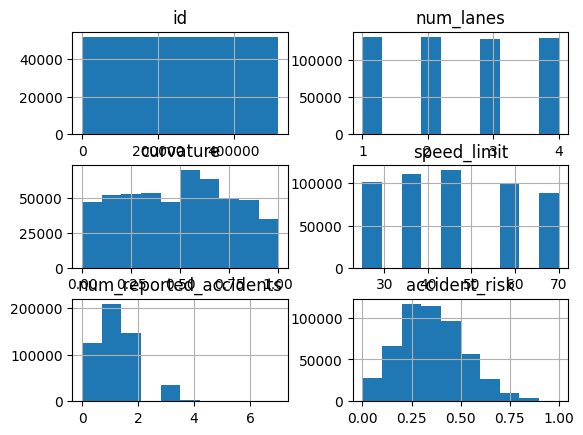

In [19]:
df.hist()

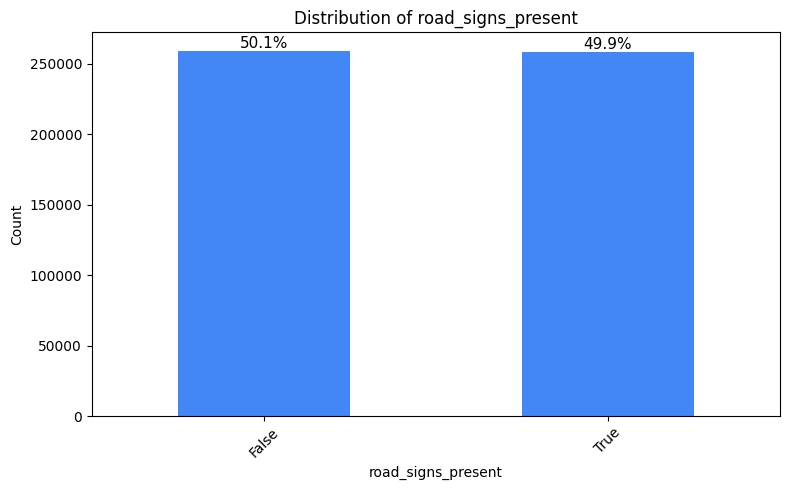

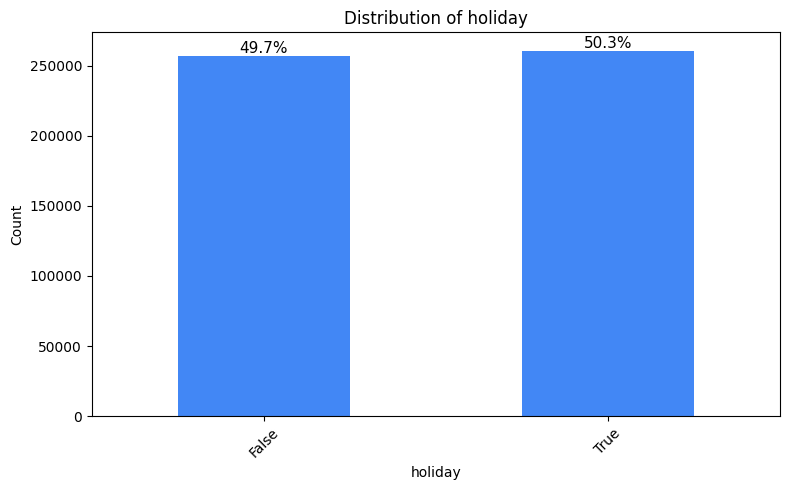

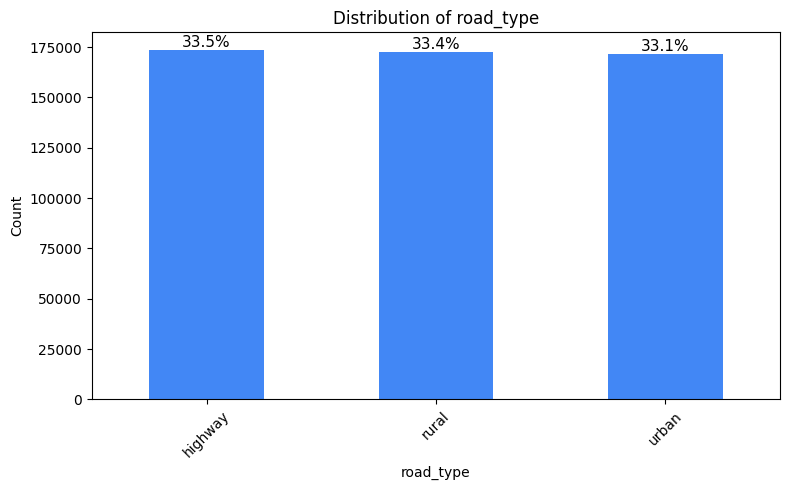

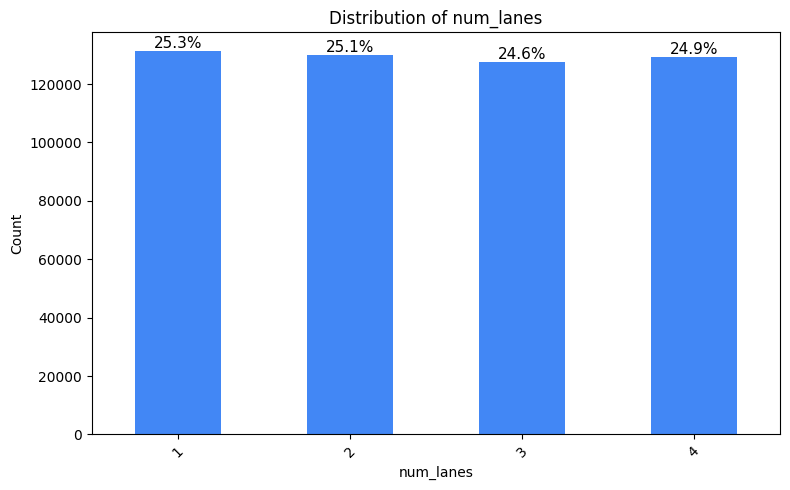

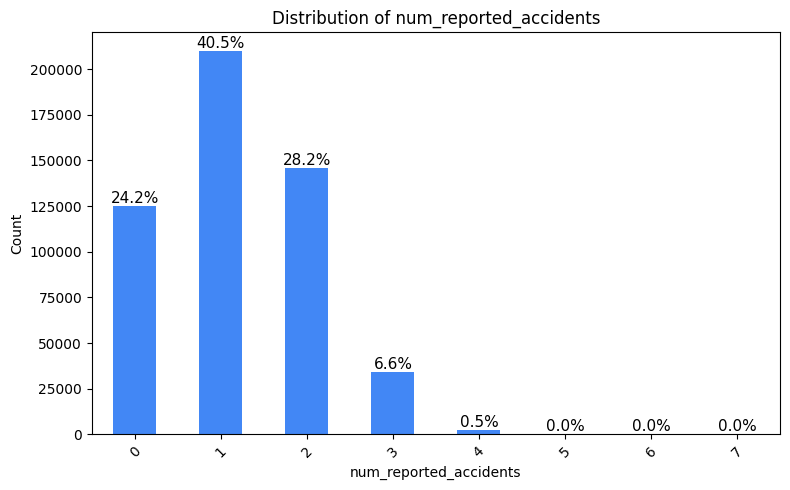

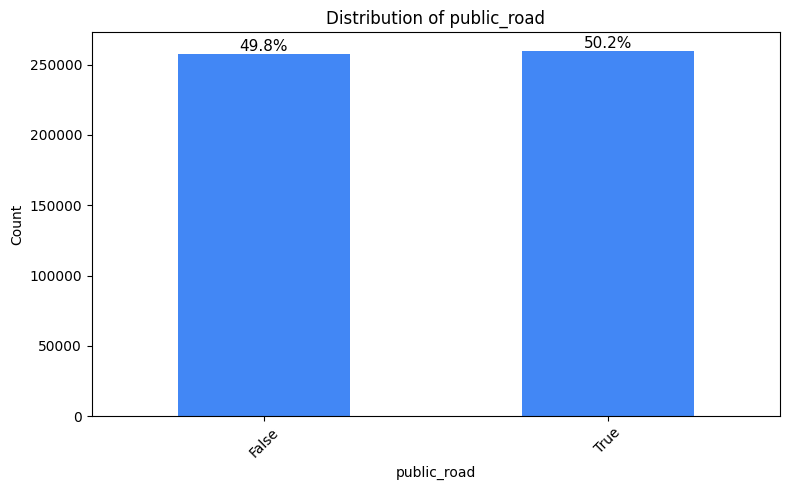

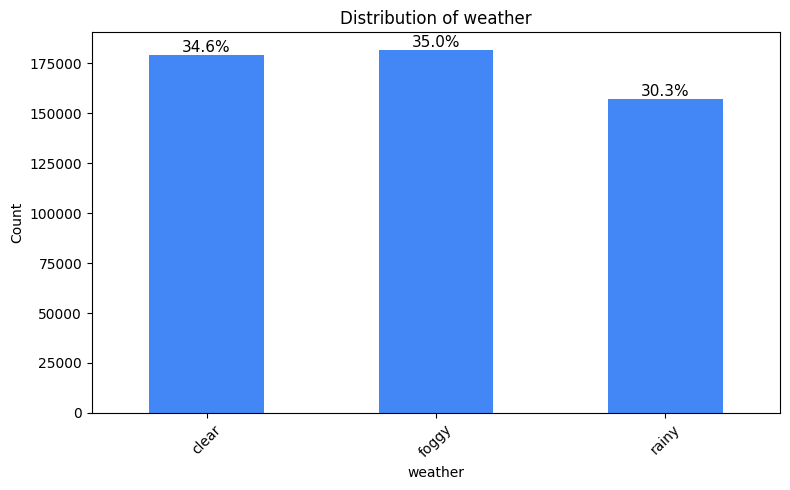

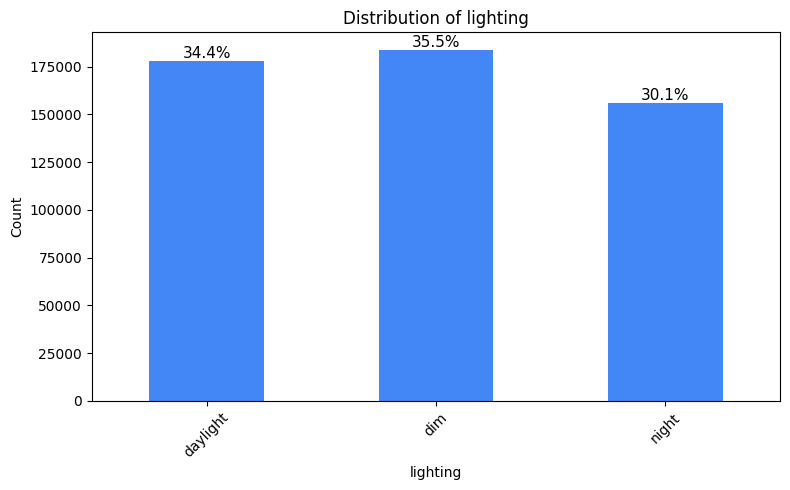

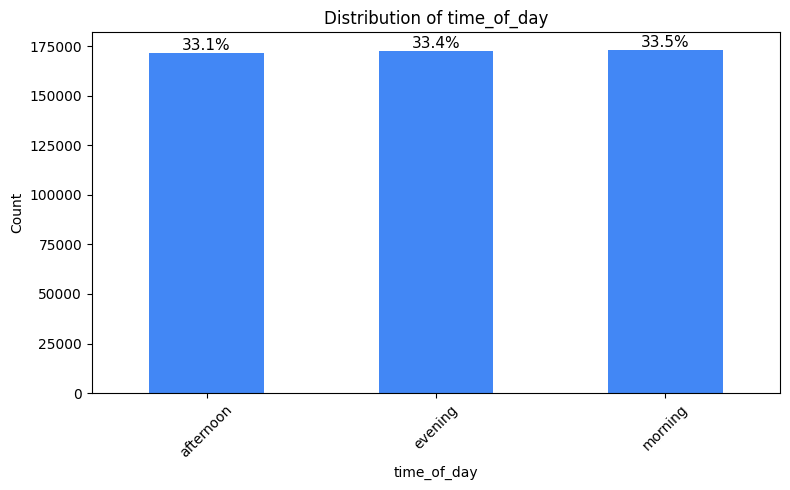

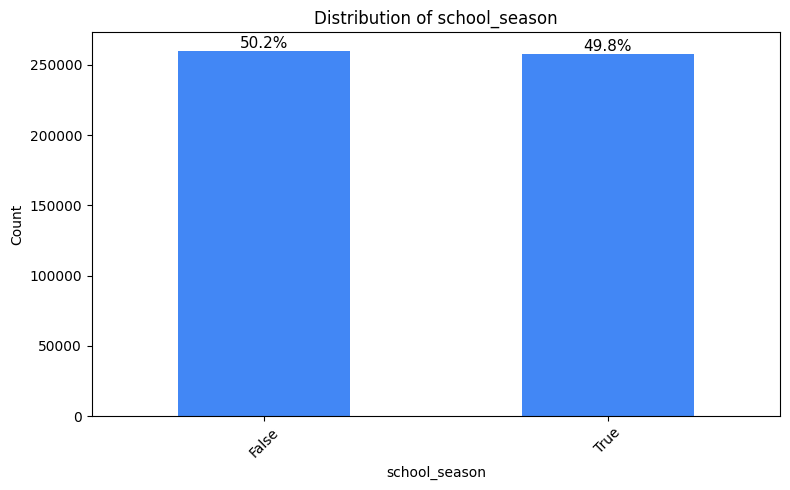

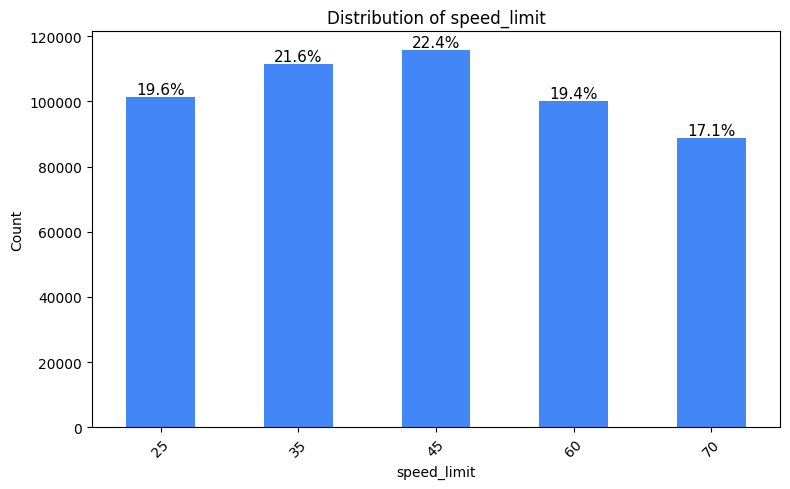

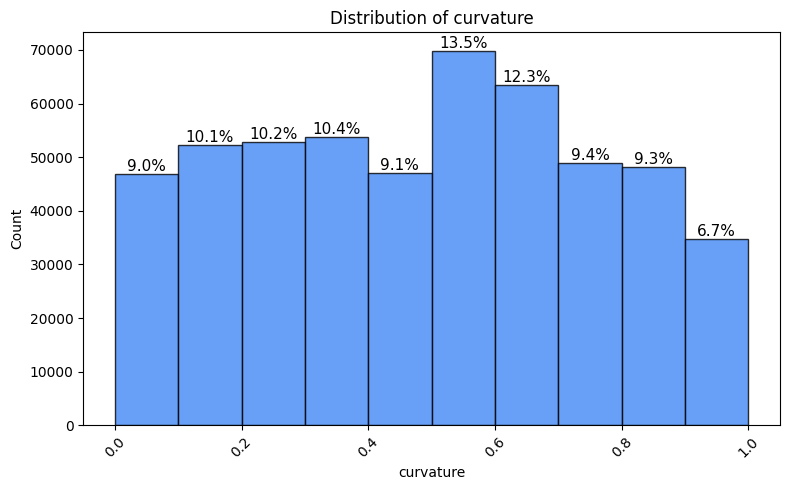

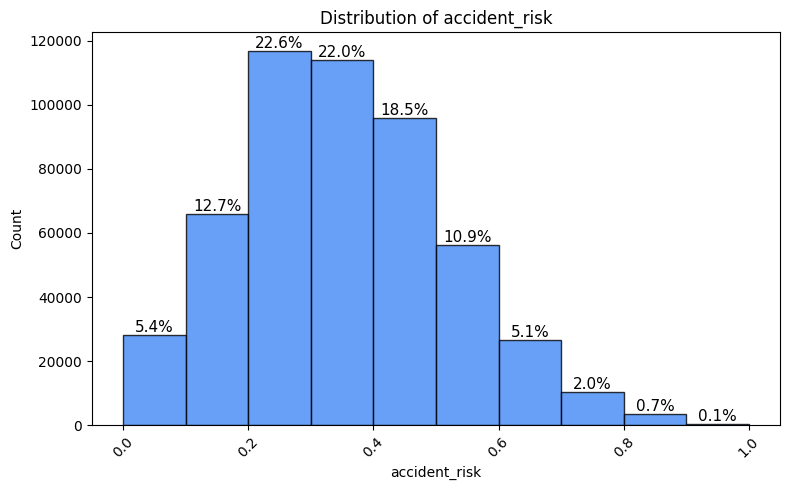

In [20]:
# Find categorical columns by dtype
cat_by_dtype = df.select_dtypes(include=['object', 'category', 'bool']).columns.tolist()

# Find columns (any dtype) with unique values < 10 (excluding target/numeric IDs as needed)
cat_by_nunique = [col for col in df.columns if df[col].nunique(dropna=False) < 10]

# Combine and deduplicate
categorical_cols = list(set(cat_by_dtype + cat_by_nunique))

# For remaining columns, treat as numerical (excluding categorical and non-numeric columns)
numerical_cols = [col for col in df.columns 
                  if col not in categorical_cols and np.issubdtype(df[col].dtype, np.number)]

# Plot categorical bar plots
for col in categorical_cols:
    plot_categorical_bar(df, col, color='#4287f5', show_percent=True)

# Plot histograms for numerical columns
for col in numerical_cols:
    if col!='id':
        plot_numerical_hist(df, col, bins=10, show_percent=True)


### Observations:

1. The feature values don't seem with odd distribution or imbalances.
2. number of reported incident are suspiciously low though. 

# 5. Visual EDA
- [ ] Histogram/Barplot: Accident vs. Non-Accident cases  
- [ ] Barplot: Accident rate by Road Type  
- [ ] Boxplot: Speed Limit by Accident occurrence  
- [ ] Plot: Accidents by Time of Day

## let's look at correlations between different features and target

In [21]:
features = df.drop('accident_risk', axis=1)

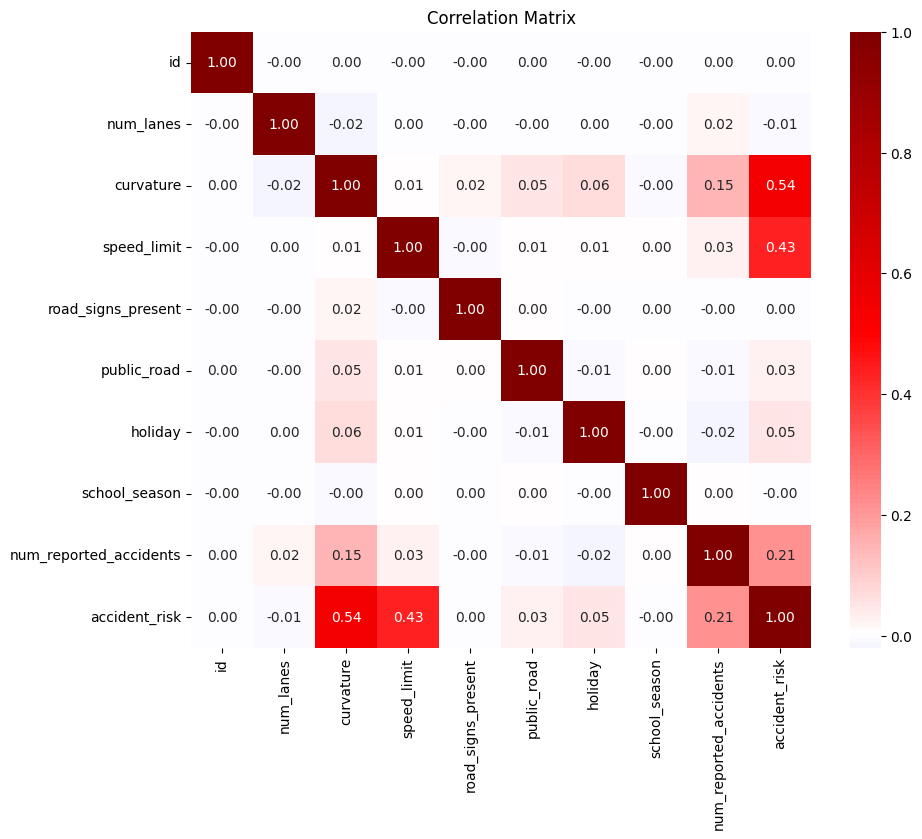

In [22]:
corr_matrix = df.corr(numeric_only=True)  # or df.corr() if all num
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10,8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='seismic', center=0)
plt.title("Correlation Matrix")
plt.show()

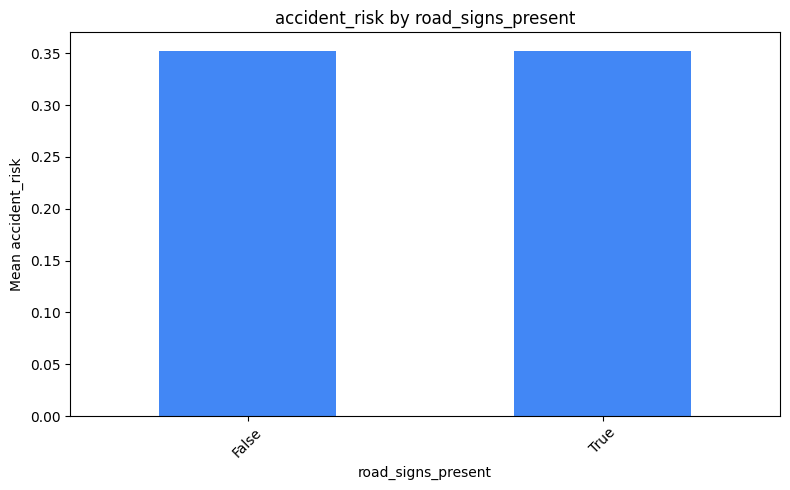

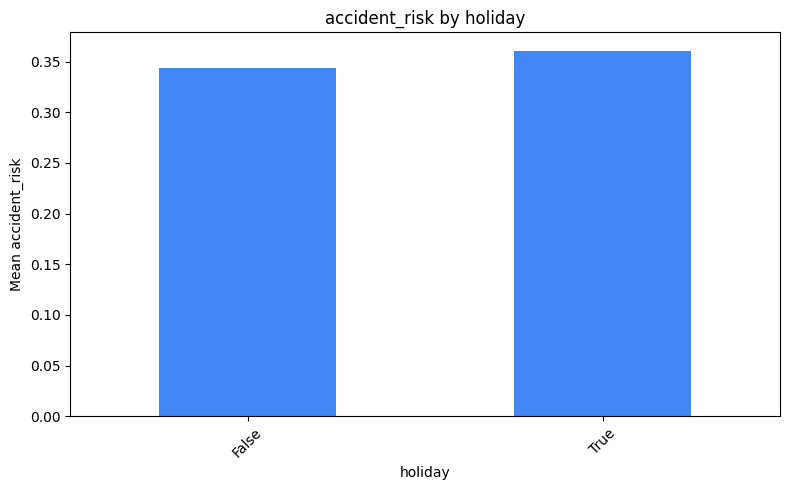

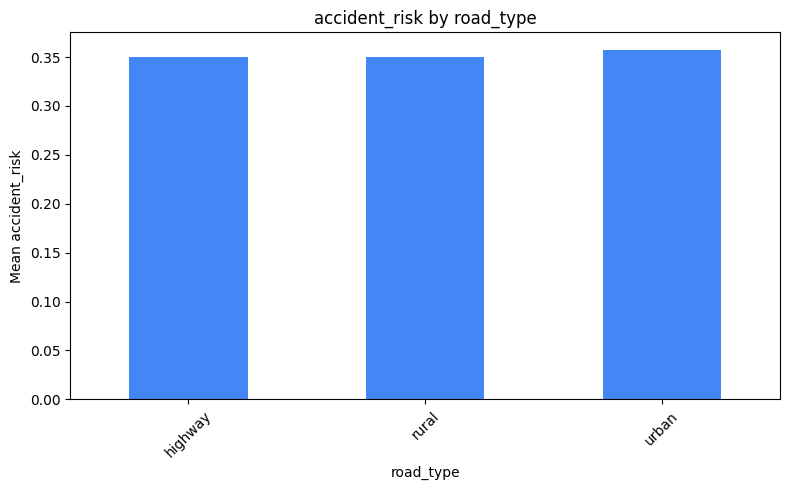

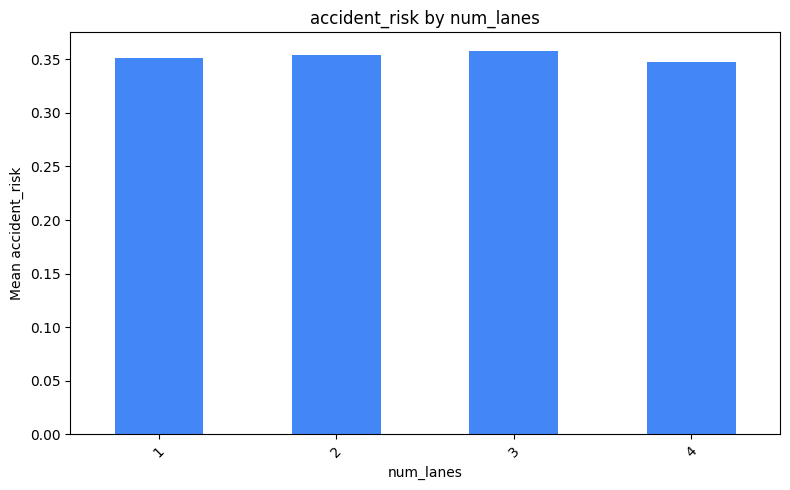

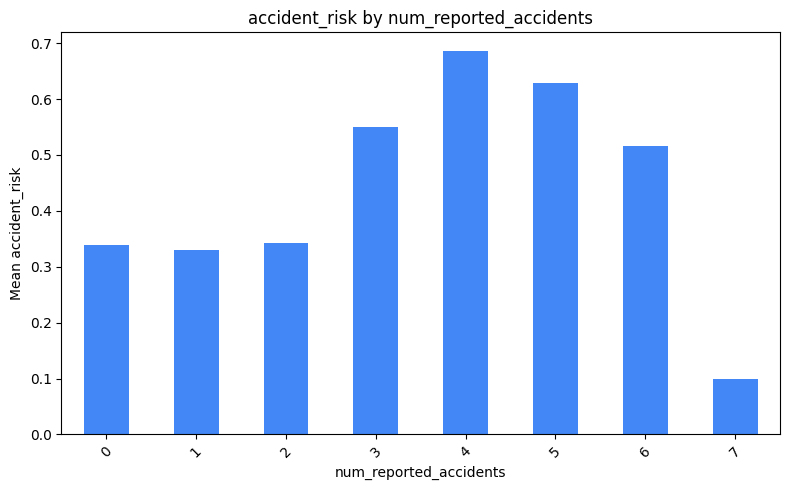

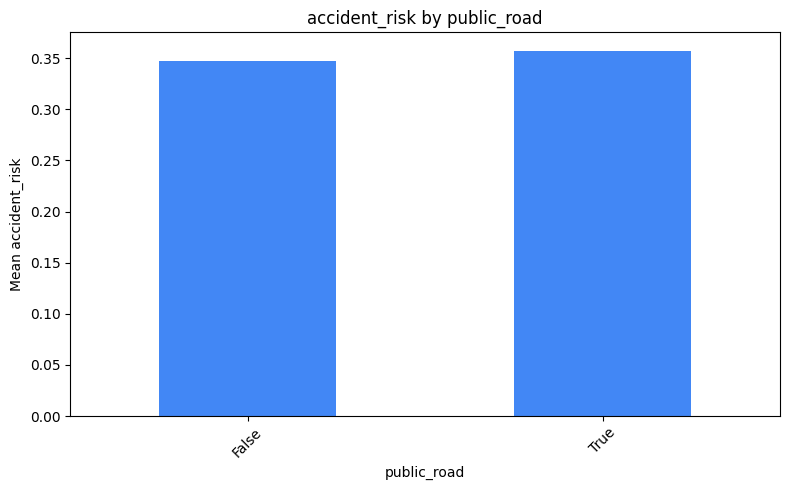

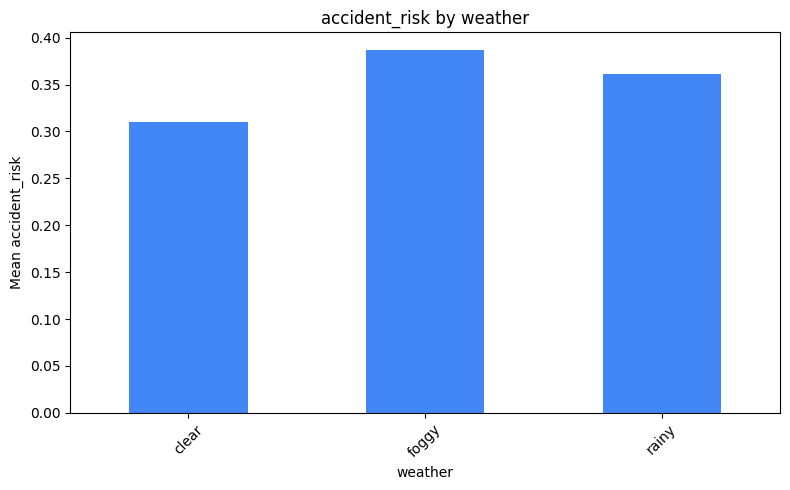

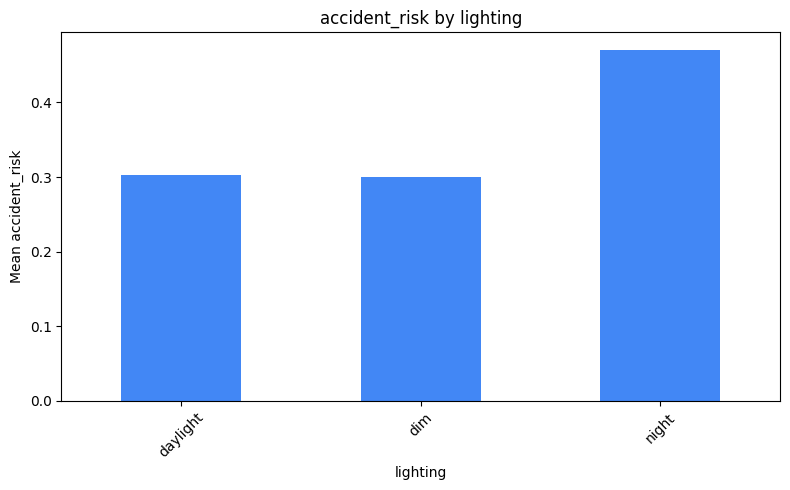

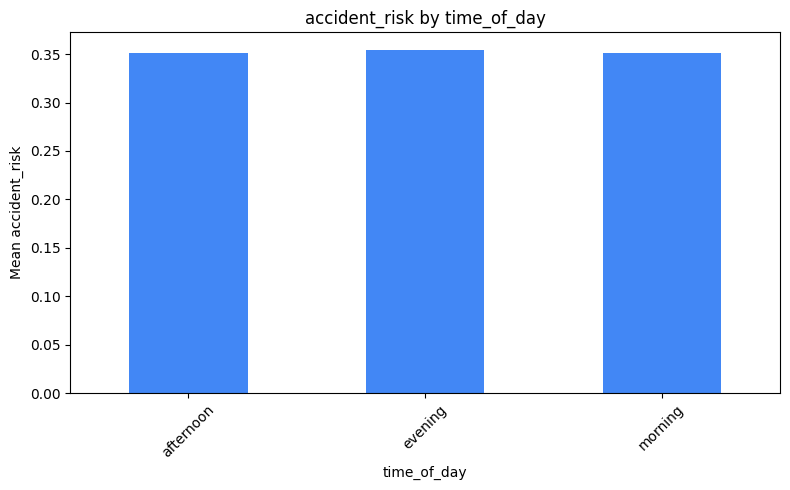

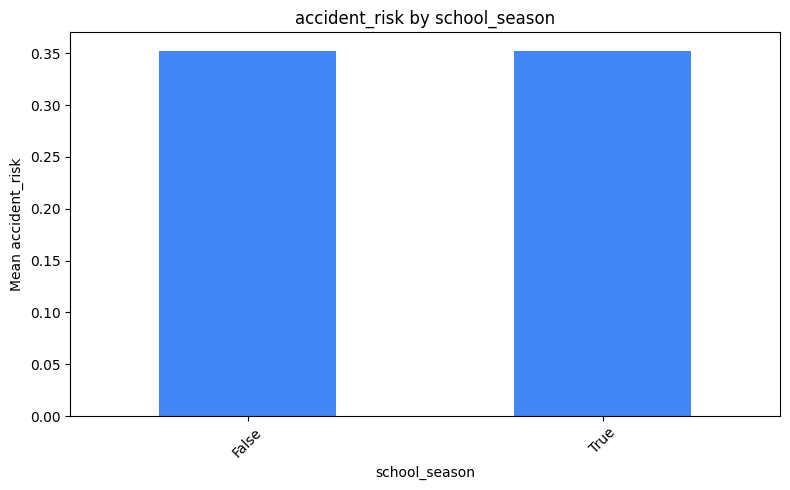

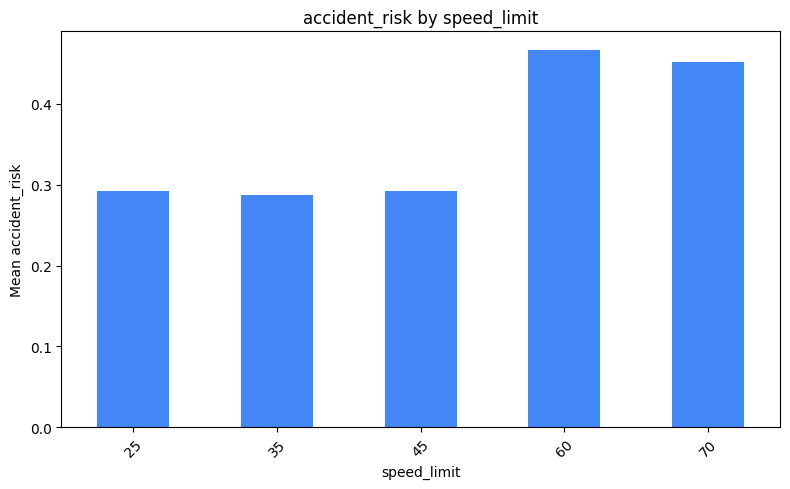

In [23]:
for col in categorical_cols:
    plot_bivariate_bar(df, col, 'accident_risk', top_n=None, figsize=(8,5), color='#4287f5', sort='value', show_count=False)

It's strange that accidents risk for highest_reported_accidents is lowest, could be sign of outlier

In [24]:
df[df['num_reported_accidents']==7]

id road_type  num_lanes  curvature  speed_limit  lighting weather  \
60437    60437     urban          2       0.27           35     night   clear   
102140  102140     urban          3       0.00           70  daylight   foggy   

        road_signs_present  public_road time_of_day  holiday  school_season  \
60437                False         True     evening     True          False   
102140               False         True   afternoon     True           True   

        num_reported_accidents  accident_risk  
60437                        7            0.1  
102140                       7            0.1

In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517754 entries, 0 to 517753
Data columns (total 14 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   id                      517754 non-null  int64  
 1   road_type               517754 non-null  object 
 2   num_lanes               517754 non-null  int64  
 3   curvature               517754 non-null  float64
 4   speed_limit             517754 non-null  int64  
 5   lighting                517754 non-null  object 
 6   weather                 517754 non-null  object 
 7   road_signs_present      517754 non-null  bool   
 8   public_road             517754 non-null  bool   
 9   time_of_day             517754 non-null  object 
 10  holiday                 517754 non-null  bool   
 11  school_season           517754 non-null  bool   
 12  num_reported_accidents  517754 non-null  int64  
 13  accident_risk           517754 non-null  float64
dtypes: bool(4), float64(

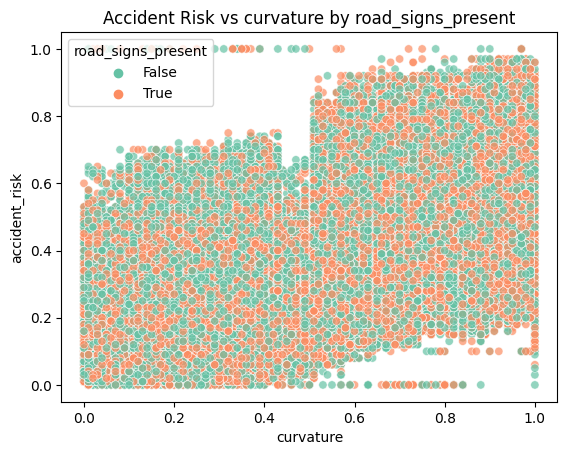

In [26]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.scatterplot(
    data=df,
    x='curvature',          # x-axis column
    y='accident_risk',      # y-axis column
    hue='road_signs_present',        # (optional) adds color for categories
    palette='Set2',         # (optional) choose color palette
    alpha=0.7               # transparency
)
plt.title('Accident Risk vs curvature by road_signs_present')
plt.show()

In [27]:
fig_df = df.copy()

fig_df['high_curvature'] = fig_df['curvature']>0.5

In [28]:
fig_df.groupby(['high_curvature','lighting'])['accident_risk'].mean()

high_curvature  lighting
False           daylight    0.226299
                dim         0.225758
                night       0.363635
True            daylight    0.378126
                dim         0.378260
                night       0.562874
Name: accident_risk, dtype: float64

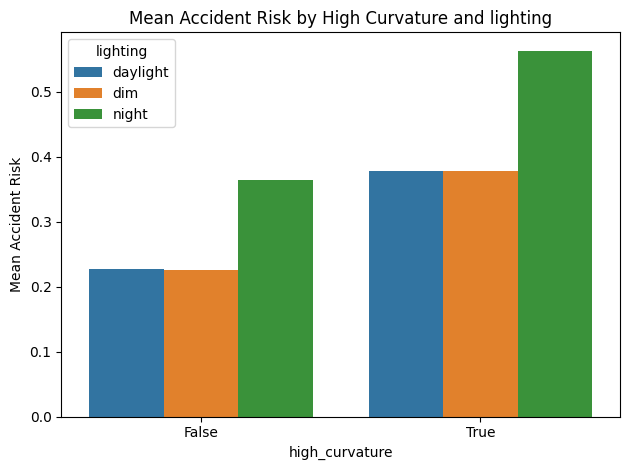

In [29]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.barplot(
    data=fig_df,
    x='high_curvature',
    y='accident_risk',
    hue='lighting',
    estimator='mean',
    ci=None
)
plt.title('Mean Accident Risk by High Curvature and lighting')
plt.ylabel('Mean Accident Risk')
plt.xlabel('high_curvature')
plt.tight_layout()
plt.show()

In [30]:
fig_df.groupby(['high_curvature','num_lanes'])['accident_risk'].mean()

high_curvature  num_lanes
False           1            0.262620
                2            0.262972
                3            0.266460
                4            0.268230
True            1            0.435660
                2            0.439670
                3            0.441255
                4            0.430616
Name: accident_risk, dtype: float64

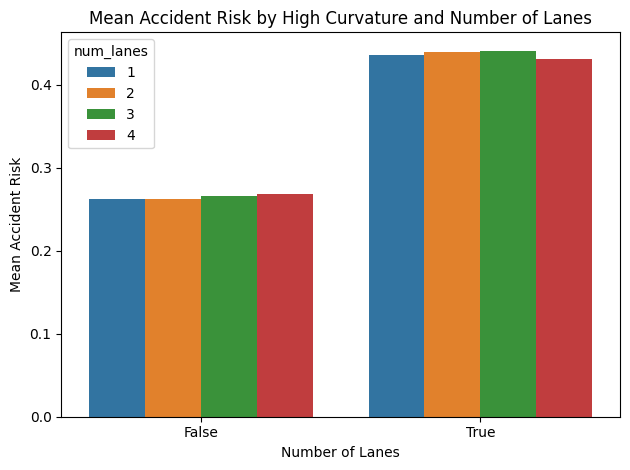

In [31]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.barplot(
    data=fig_df,
    x='high_curvature',
    y='accident_risk',
    hue='num_lanes',
    estimator='mean',
    ci=None
)
plt.title('Mean Accident Risk by High Curvature and Number of Lanes')
plt.ylabel('Mean Accident Risk')
plt.xlabel('Number of Lanes')
plt.tight_layout()
plt.show()

In [32]:
fig_df = df.copy()

fig_df.groupby(['lighting','time_of_day'])['accident_risk'].mean()

lighting  time_of_day
daylight  afternoon      0.302273
          evening        0.305657
          morning        0.300836
dim       afternoon      0.298801
          evening        0.303865
          morning        0.297691
night     afternoon      0.472374
          evening        0.469456
          morning        0.469635
Name: accident_risk, dtype: float64

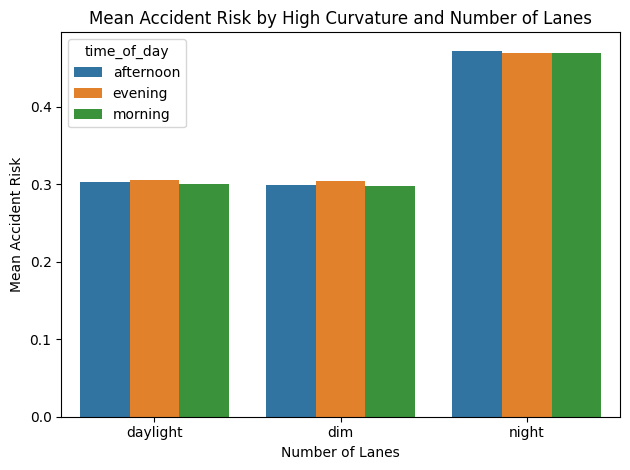

In [33]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.barplot(
    data=fig_df,
    x='lighting',
    y='accident_risk',
    hue='time_of_day',
    estimator='mean',
    ci=None
)
plt.title('Mean Accident Risk by High Curvature and Number of Lanes')
plt.ylabel('Mean Accident Risk')
plt.xlabel('Number of Lanes')
plt.tight_layout()
plt.show()

## bivariate analyisis between high risk and categorical columns

In [34]:
not_imp_features = {}

fig_df['high_risk']= fig_df['accident_risk']>0.7
for column in categorical_cols: 
    print(f'investigation for {column}')
    chi_square, p=  get_chi2(fig_df, 'high_risk', column)
    if p>0.05:
        not_imp_features[column]={'chi_square':chi_square, 
                               'p':  p}

investigation for road_signs_present
Chi2: 23.202508, p-value: 0.000001
investigation for holiday
Chi2: 98.723633, p-value: 0.000000
investigation for road_type
Chi2: 12.512428, p-value: 0.001918
investigation for num_lanes
Chi2: 66.445620, p-value: 0.000000
investigation for num_reported_accidents
Chi2: 58347.059595, p-value: 0.000000
investigation for public_road
Chi2: 58.899235, p-value: 0.000000
investigation for weather
Chi2: 3045.753952, p-value: 0.000000
investigation for lighting
Chi2: 28474.898223, p-value: 0.000000
investigation for time_of_day
Chi2: 0.427732, p-value: 0.807457
investigation for school_season
Chi2: 19.165196, p-value: 0.000012
investigation for speed_limit
Chi2: 23051.028515, p-value: 0.000000


In [35]:
not_imp_features

{'time_of_day': {'chi_square': 0.4277320778580406, 'p': 0.8074565455214793}}

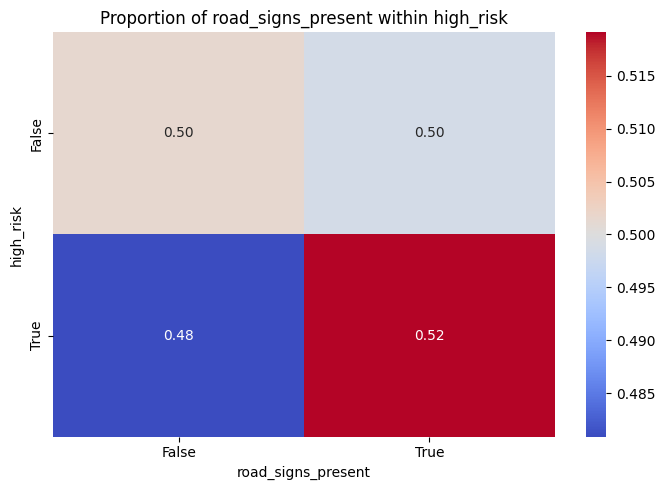

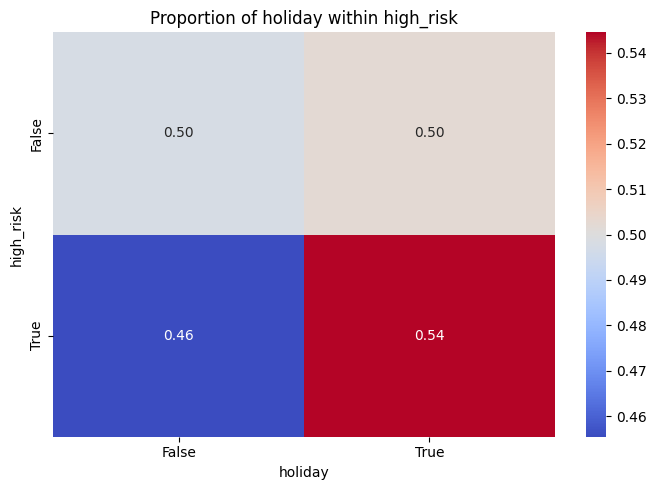

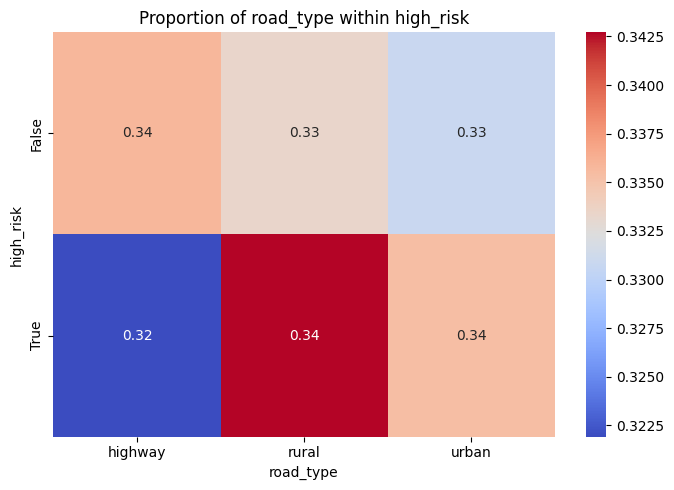

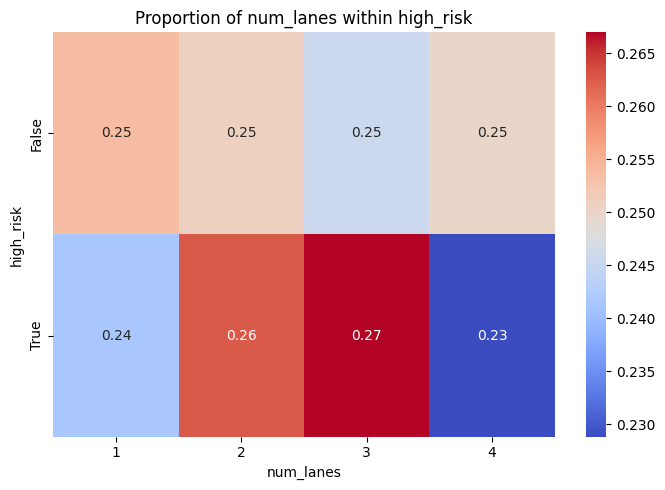

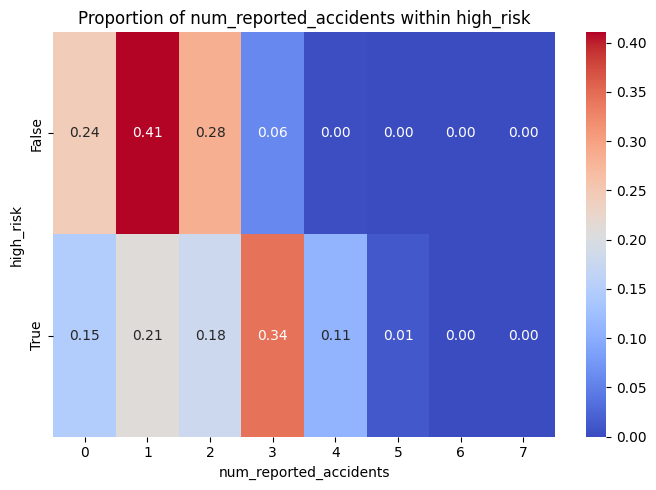

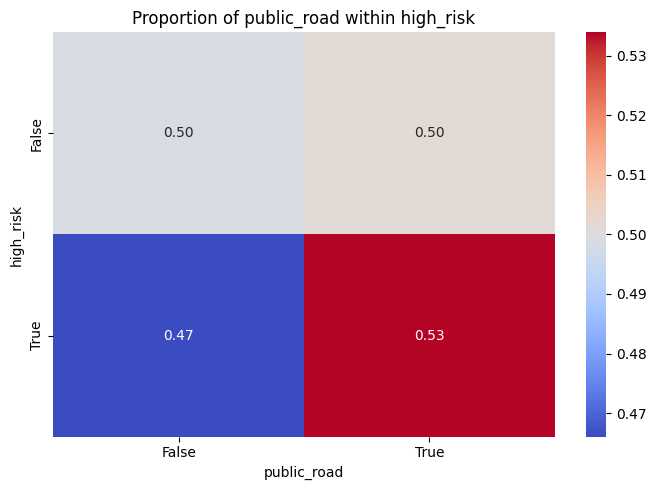

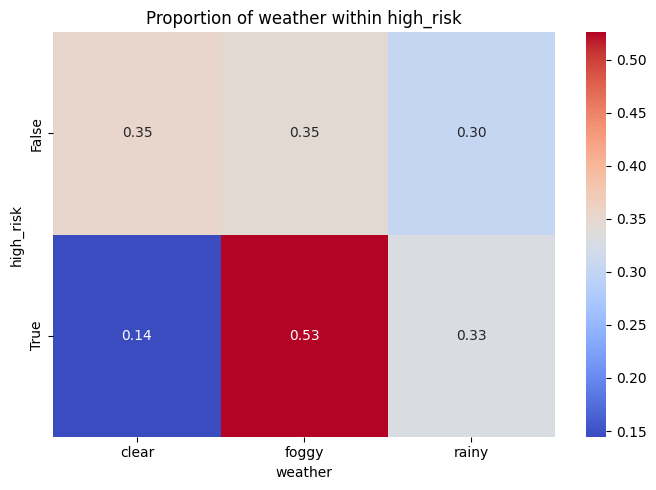

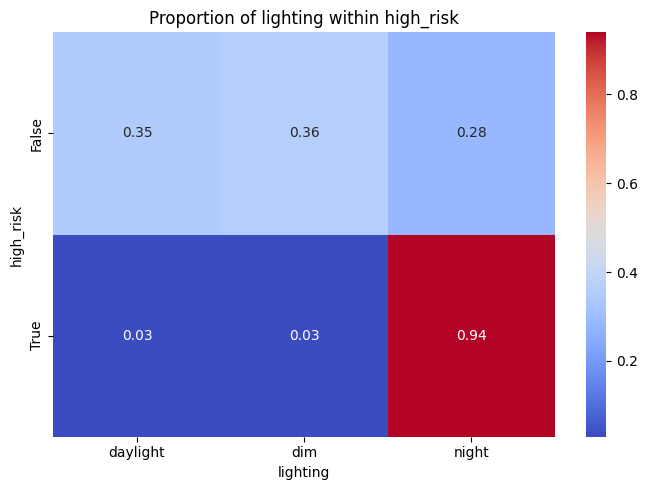

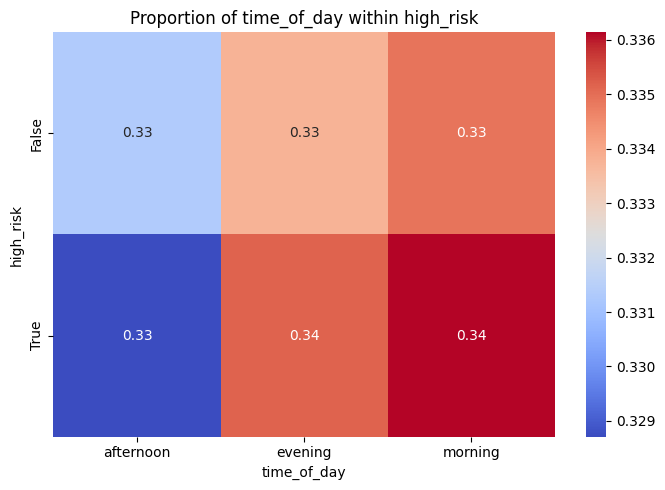

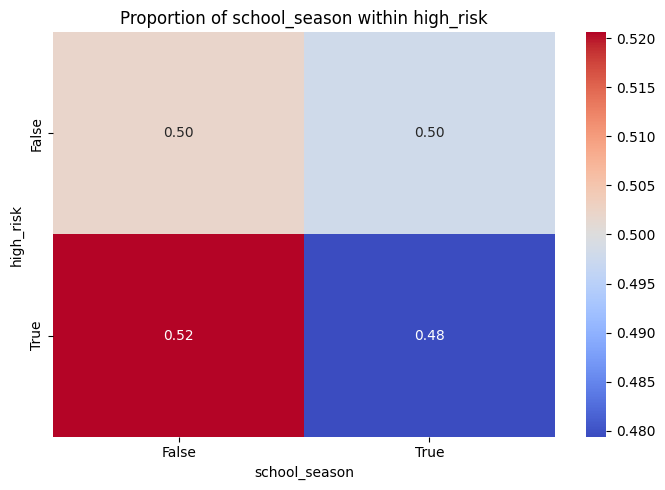

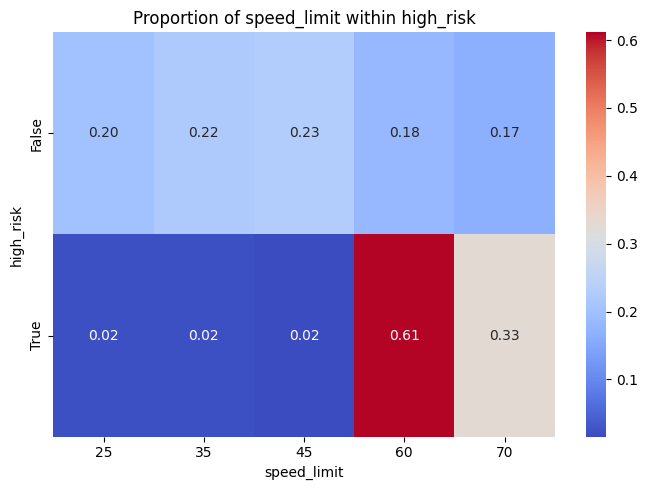

In [36]:
for column in categorical_cols: 
    plot_crosstab_heatmap(fig_df, 'high_risk', column, normalize='row', cmap='coolwarm', fmt='.2f', figsize=(7,5))

### Observations: 

1. From above figures, we can say that time of the day is not useful in predicting the high_risk accident and from the bar plot it's not very helpful in predicting the accident risk either. Perhaps it can be dropped.
2. Also, even though road_signs_present flag is showing it's impact in high_risk cases, where it's present is in 52% of high risk(>0.7), it might better work in some combination as it's mean impact in the bar plot doesn't show it's usefulness. Let's analyse it further.

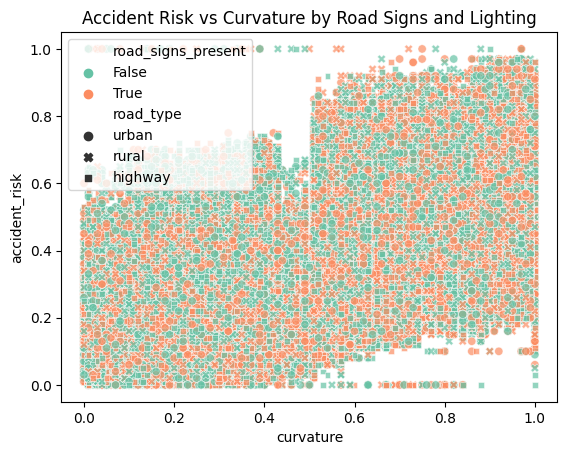

In [37]:
import seaborn as sns
import matplotlib.pyplot as plt


sns.scatterplot(
    data=df,
    x='curvature',
    y='accident_risk',
    hue='road_signs_present',
    style='road_type',
    palette='Set2',
    alpha=0.7
)
plt.title('Accident Risk vs Curvature by Road Signs and Lighting')
plt.legend()
plt.show()

In [38]:
# Assuming road_signs_present is numeric (e.g. count or binary)
pivot = fig_df.pivot_table(
    index='lighting',
    columns='high_risk',     # Make sure df["high_risk"] is defined: df['accident_risk'] > 0.5
    values='road_signs_present',
    aggfunc='mean'
)

print(pivot)


high_risk     False     True 
lighting                     
daylight   0.503475  0.516854
dim        0.499441  0.489157
night      0.491582  0.520110


We couldn't find any evidence that road_sign makes significant impact on accident_risk

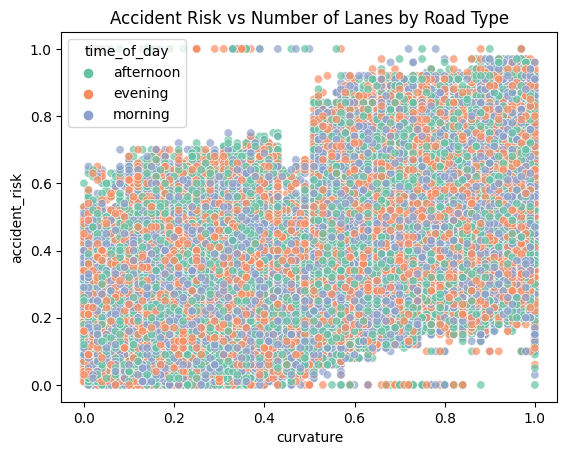

In [39]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.scatterplot(
    data=df,
    x='curvature',          # x-axis column
    y='accident_risk',      # y-axis column
    hue='time_of_day',        # (optional) adds color for categories
    palette='Set2',         # (optional) choose color palette
    alpha=0.7               # transparency
)
plt.title('Accident Risk vs Number of Lanes by Road Type')
plt.show()

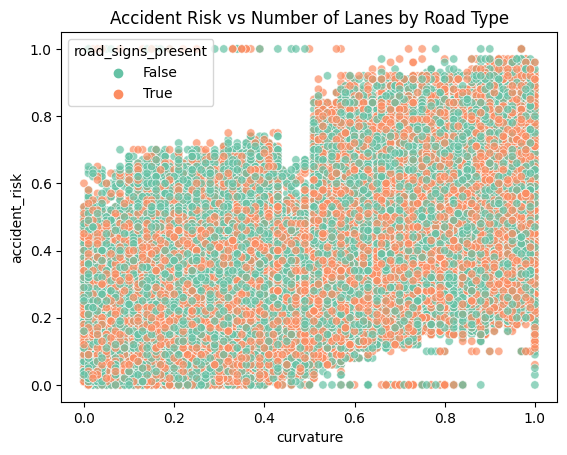

In [40]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.scatterplot(
    data=df,
    x='curvature',          # x-axis column
    y='accident_risk',      # y-axis column
    hue='road_signs_present',        # (optional) adds color for categories
    palette='Set2',         # (optional) choose color palette
    alpha=0.7               # transparency
)
plt.title('Accident Risk vs Number of Lanes by Road Type')
plt.show()

<Axes: xlabel='lighting', ylabel='accident_risk'>

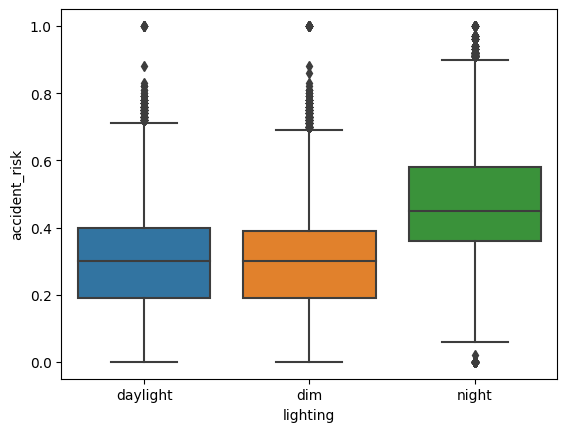

In [41]:
sns.boxplot(x='lighting', y='accident_risk', data=df)

<Axes: xlabel='time_of_day', ylabel='accident_risk'>

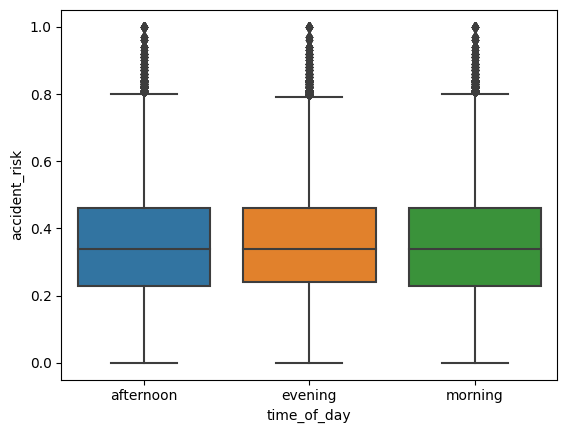

In [42]:
sns.boxplot(x='time_of_day', y='accident_risk', data=df)

yet another evidence that time of day is not very usefull in predicting accident_risk

<Axes: xlabel='lighting', ylabel='accident_risk'>

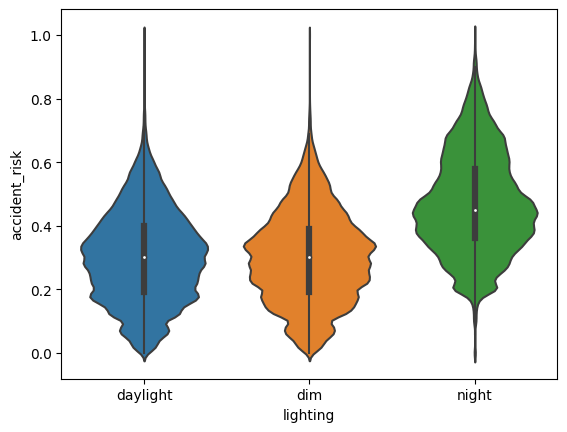

In [43]:
sns.violinplot(x='lighting', y='accident_risk', data=df)

<Axes: xlabel='time_of_day', ylabel='accident_risk'>

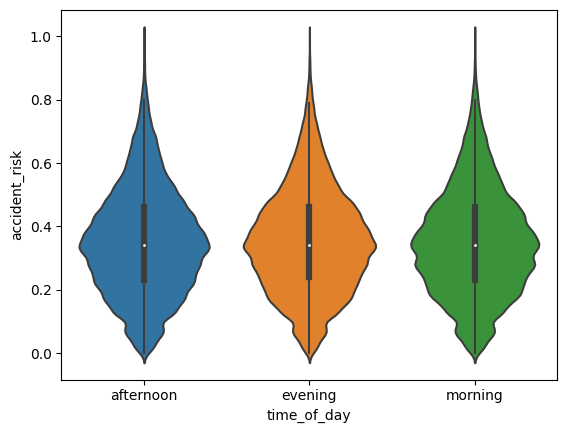

In [44]:
sns.violinplot(x='time_of_day', y='accident_risk', data=df)

<Axes: xlabel='road_type', ylabel='accident_risk'>

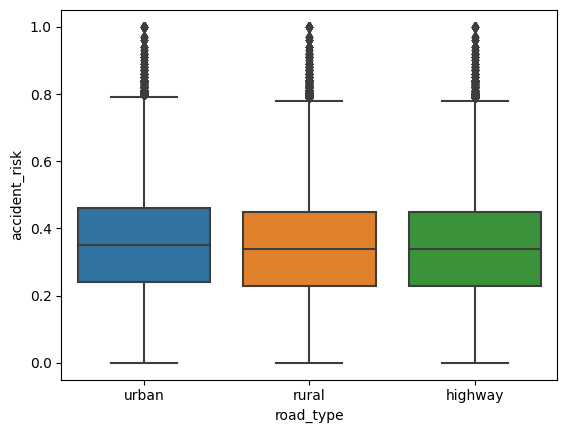

In [45]:
sns.boxplot(x='road_type', y='accident_risk', data=df)

<Axes: xlabel='num_lanes', ylabel='accident_risk'>

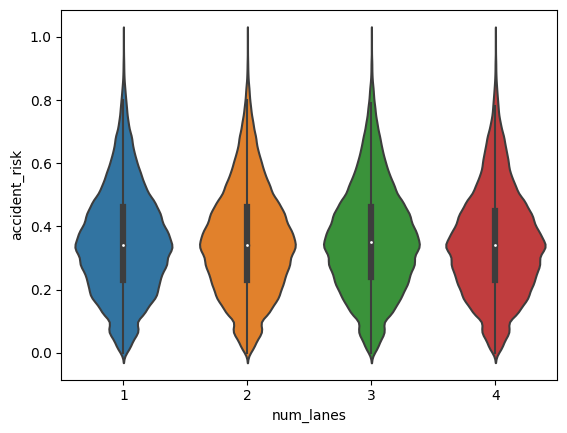

In [46]:
sns.violinplot(x='num_lanes', y='accident_risk', data=df)

<Axes: xlabel='weather', ylabel='accident_risk'>

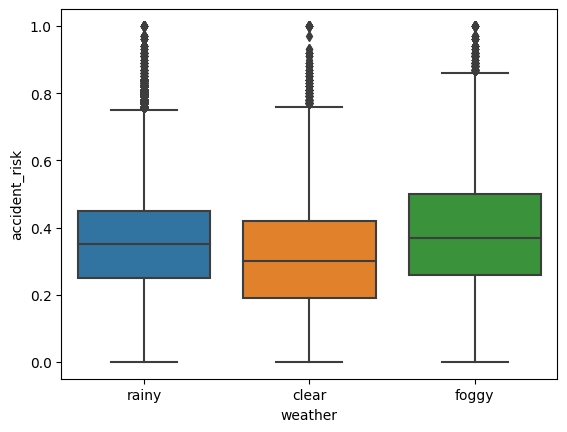

In [47]:
sns.boxplot(x='weather', y='accident_risk', data=df)

<Axes: xlabel='road_signs_present', ylabel='accident_risk'>

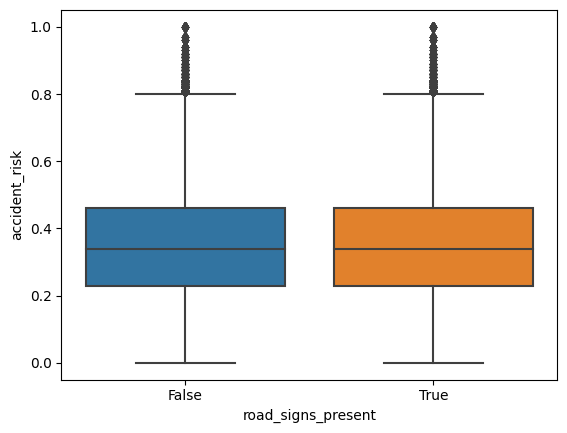

In [48]:
sns.boxplot(x='road_signs_present', y='accident_risk', data=df)

 road signs don't seem to impact.

<Axes: xlabel='speed_limit', ylabel='accident_risk'>

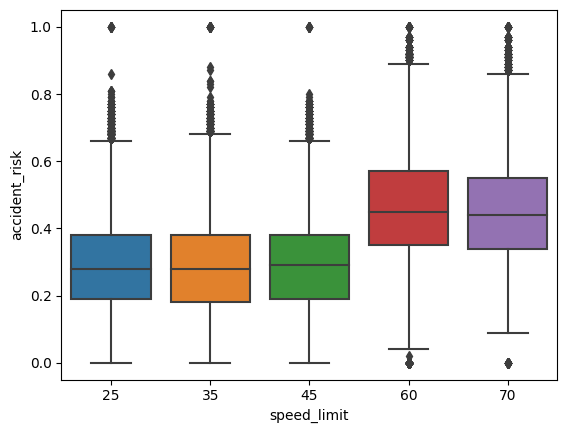

In [49]:
sns.boxplot(x='speed_limit', y='accident_risk', data=df)

speed and risk are clearly split between two categories, <=45 lower rate and >=45 higher risks. We can perhaps make a high speed boolean


In [50]:
fig_df['high_risk'] = fig_df['accident_risk']>0.7
fig_df['high_speed'] = fig_df['speed_limit']>=50

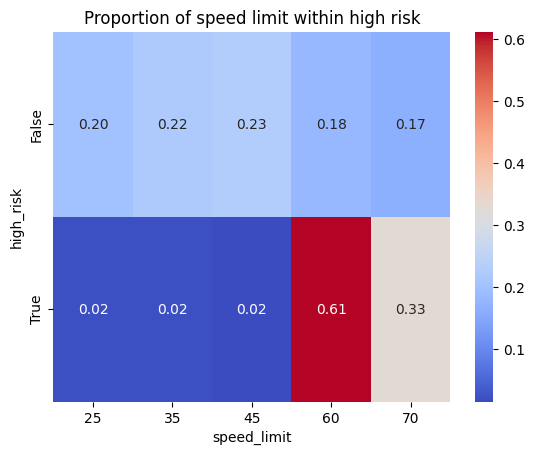

In [51]:
from scipy.stats import chi2_contingency
import seaborn as sns
import matplotlib.pyplot as plt

table = pd.crosstab(fig_df['high_risk'], fig_df['speed_limit'])


# Normalize by row (lighting)
proportions = table.div(table.sum(axis=1), axis=0)
sns.heatmap(proportions, annot=True, fmt=".2f", cmap="coolwarm")
plt.title('Proportion of speed limit within high risk')
plt.show()


In [52]:
pd.crosstab(fig_df['high_speed'], fig_df['high_risk'])

high_risk    False  True 
high_speed               
False       327956    846
True        175512  13440

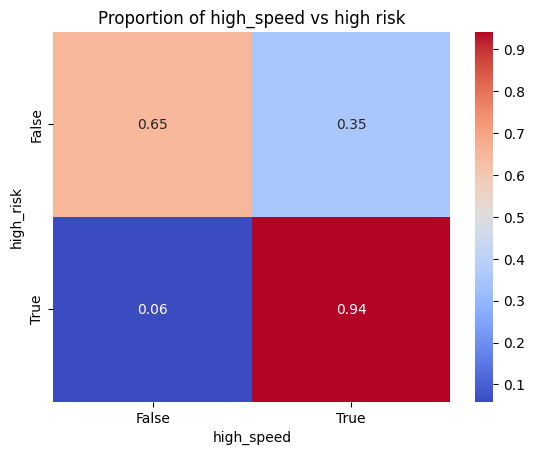

In [53]:
from scipy.stats import chi2_contingency

table = pd.crosstab(fig_df['high_risk'], fig_df['high_speed'])
proportions = table.div(table.sum(axis=1), axis=0)
sns.heatmap(proportions, annot=True, fmt=".2f", cmap="coolwarm")
plt.title('Proportion of high_speed vs high risk')
plt.show()

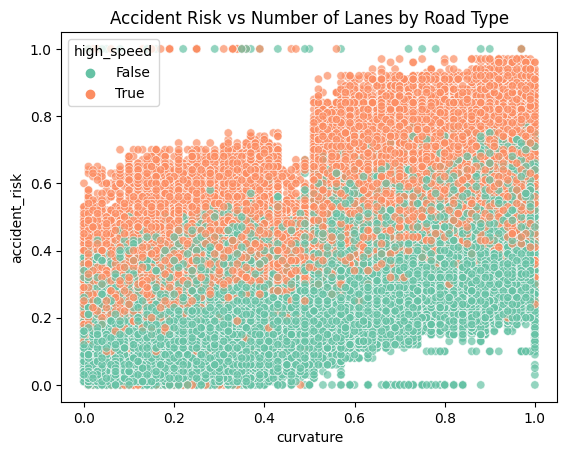

In [54]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.scatterplot(
    data=fig_df,
    x='curvature',          # x-axis column
    y='accident_risk',      # y-axis column
    hue='high_speed',        # (optional) adds color for categories
    palette='Set2',         # (optional) choose color palette
    alpha=0.7               # transparency
)
plt.title('Accident Risk vs Number of Lanes by Road Type')
plt.show()

<Axes: xlabel='high_speed', ylabel='accident_risk'>

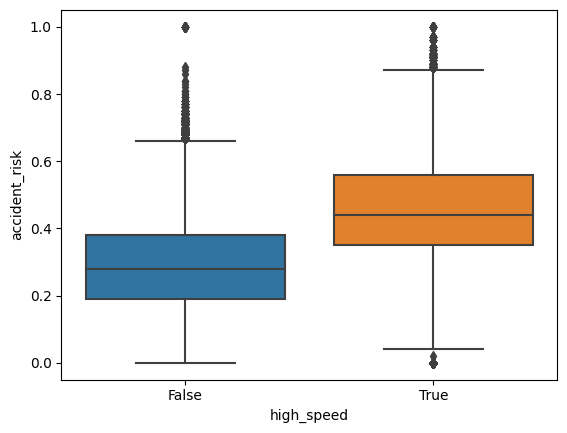

In [55]:
sns.boxplot(x='high_speed', y='accident_risk', data=fig_df)

In [56]:
fig_df['is_clear']=fig_df['weather']=='clear'
fig_df['is_dark']= fig_df['lighting']=='night'
fig_df['is_evening']= fig_df['time_of_day'] =='evening'
fig_df['is_foggy']=fig_df['weather']=='foggy'
fig_df['is_urban']=fig_df['road_type']=='urban'

In [57]:
fig_df.corr(numeric_only=True)  # or df.corr() if all num

id  num_lanes  curvature  speed_limit  \
id                      1.000000  -0.000434   0.000938    -0.000678   
num_lanes              -0.000434   1.000000  -0.020245     0.001194   
curvature               0.000938  -0.020245   1.000000     0.008399   
speed_limit            -0.000678   0.001194   0.008399     1.000000   
road_signs_present     -0.001594  -0.000498   0.017168    -0.004461   
public_road             0.000554  -0.002041   0.048220     0.011497   
holiday                -0.001582   0.002544   0.063931     0.010992   
school_season          -0.001567  -0.001081  -0.004502     0.004392   
num_reported_accidents  0.000104   0.017662   0.145034     0.031373   
accident_risk           0.000969  -0.006003   0.543946     0.430898   
high_risk               0.001771  -0.001281   0.176867     0.166830   
high_speed             -0.001085   0.000458   0.021328     0.892051   
is_clear               -0.002424   0.003489   0.016058     0.077258   
is_dark                 0.001559  -0.001150   0.000850    -0.076318   
is_evening             -0.001539  -0.001021   0.002818     0.000252   
is_foggy                0.000267   0.002897   0.045515    -0.001255   
is_urban                0.000473   0.000455   0.010403     0.008298   

                        road_signs_present  public_road   holiday  \
id                               -0.001594     0.000554 -0.001582   
num_lanes                        -0.000498    -0.002041  0.002544   
curvature                         0.017168     0.048220  0.063931   
speed_limit                      -0.004461     0.011497  0.010992   
road_signs_present                1.000000     0.003828 -0.003813   
public_road                       0.003828     1.000000 -0.007920   
holiday                          -0.003813    -0.007920  1.000000   
school_season                     0.002287     0.004117 -0.001514   
num_reported_accidents           -0.000162    -0.007026 -0.015053   
accident_risk                     0.000629     0.031032  0.051129   
high_risk                         0.006706     0.010678  0.013820   
high_speed                       -0.005646     0.012130  0.012944   
is_clear                         -0.002649    -0.009933 -0.019349   
is_dark                          -0.006782     0.000057  0.016977   
is_evening                       -0.004906    -0.001142 -0.003769   
is_foggy                         -0.003685    -0.000056 -0.002123   
is_urban                          0.000705    -0.000058 -0.000336   

                        school_season  num_reported_accidents  accident_risk  \
id                          -0.001567                0.000104       0.000969   
num_lanes                   -0.001081                0.017662      -0.006003   
curvature                   -0.004502                0.145034       0.543946   
speed_limit                  0.004392                0.031373       0.430898   
road_signs_present           0.002287               -0.000162       0.000629   
public_road                  0.004117               -0.007026       0.031032   
holiday                     -0.001514               -0.015053       0.051129   
school_season                1.000000                0.003962      -0.000977   
num_reported_accidents       0.003962                1.000000       0.213891   
accident_risk               -0.000977                0.213891       1.000000   
high_risk                   -0.006096                0.170607       0.423487   
high_speed                   0.004009                0.033475       0.487876   
is_clear                     0.001451               -0.037678      -0.185085   
is_dark                     -0.003191                0.051662       0.465798   
is_evening                  -0.006061                0.001238       0.010032   
is_foggy                    -0.004432                0.001028       0.149758   
is_urban                     0.001104                0.003660       0.021463   

                        high_risk  high_speed  is_clear   is_dark  

### Conclusion

1. Following columns do not contribute to target significantly ['time_of_day', 'road_signs_present', 'school_seasion']
2. Also the num of accidents reported = 7 has only 2 rows, which is not enough to draw conclusion. So, best option is to drop as it seems to show low risk, which seems counter intutive

# 6. Train/Test Setup
- [ ] Split data → hold out 10–20% as final test set 

In [58]:
df = pd.read_csv("/kaggle/input/playground-series-s5e10/train.csv")


df = df[df['num_reported_accidents']!=7]
df = df[(df['accident_risk']!=0) &(df['accident_risk']!=0)  ]

In [59]:
from sklearn.model_selection import train_test_split

y = df["accident_risk"]
X = df.drop('accident_risk', axis=1)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [60]:
X_train

id road_type  num_lanes  curvature  speed_limit  lighting weather  \
170677  170677   highway          3       0.92           60       dim   clear   
478064  478064   highway          4       0.35           45  daylight   rainy   
362752  362752     urban          2       0.66           70     night   rainy   
128697  128697     rural          2       0.88           35     night   foggy   
463192  463192     rural          4       0.35           70       dim   foggy   
...        ...       ...        ...        ...          ...       ...     ...   
259472  259472     urban          1       0.74           45  daylight   foggy   
366257  366257     urban          2       0.22           35  daylight   clear   
132084  132084   highway          1       0.60           45     night   clear   
147034  147034   highway          4       0.68           70       dim   clear   
122100  122100     urban          1       0.75           25       dim   foggy   

        road_signs_present  public_road time_of_day  holiday  school_season  \
170677                True         True     morning    False           True   
478064                True        False     morning     True           True   
362752                True         True     evening    False          False   
128697                True        False     morning     True           True   
463192               False         True     morning    False          False   
...                    ...          ...         ...      ...            ...   
259472                True         True     morning    False          False   
366257               False        False     evening    False          False   
132084                True        False     evening     True          False   
147034               False        False   afternoon     True           True   
122100               False        False     morning     True           True   

        num_reported_accidents  
170677                       2  
478064                       2  
362752                       5  
128697                       0  
463192                       1  
...                        ...  
259472                       3  
366257                       2  
132084                       1  
147034                       0  
122100                       0  

[413715 rows x 13 columns]

# 6. Data Cleaning

## Universal data cleaner

In [61]:
import pandas as pd
import numpy as np
from sklearn.base import BaseEstimator, TransformerMixin

# -------------------------------------------------
# 1️⃣ Pre-cleaner (run before feature engineering)
# -------------------------------------------------
class PreCleaner(BaseEstimator, TransformerMixin):
    """
    Cleans NaNs, drops high-missing columns, fixes categorical issues.
    """
    def __init__(self,
                 num_strategy='median',
                 cat_strategy='mode',
                 drop_threshold=0.9):
        self.num_strategy = num_strategy
        self.cat_strategy = cat_strategy
        self.drop_threshold = drop_threshold
        self.numeric_fill_values_ = {}
        self.categorical_fill_values_ = {}
        self.columns_to_drop_ = []

    def fit(self, X, y=None):
        X = X.copy()

        # Drop columns with excessive missing
        missing_ratio = X.isnull().mean()
        self.columns_to_drop_ = missing_ratio[missing_ratio > self.drop_threshold].index.tolist()

        num_cols = X.select_dtypes(include=np.number).columns
        cat_cols = X.select_dtypes(exclude=np.number).columns

        # Numeric fill values
        for c in num_cols:
            if c in self.columns_to_drop_: continue
            if self.num_strategy == 'mean':
                self.numeric_fill_values_[c] = X[c].mean()
            else:
                self.numeric_fill_values_[c] = X[c].median()

        # Categorical fill values
        for c in cat_cols:
            if c in self.columns_to_drop_: continue
            if self.cat_strategy == 'mode':
                self.categorical_fill_values_[c] = X[c].mode().iloc[0] if not X[c].mode().empty else "Unknown"
            else:
                self.categorical_fill_values_[c] = "Unknown"

        return self

    def transform(self, X):
        X = X.copy()

        # Drop high-missing columns
        X.drop(columns=self.columns_to_drop_, inplace=True, errors='ignore')

        # Fill numeric
        for c, v in self.numeric_fill_values_.items():
            if c in X.columns:
                X[c] = X[c].fillna(v)

        # Fill categorical + clean strings
        for c, v in self.categorical_fill_values_.items():
            if c in X.columns:
                X[c] = X[c].replace(['?', 'NA', 'N/A', '', 'None'], np.nan).fillna(v)
                X[c] = X[c].astype(str).str.strip().str.title()

        return X


# -------------------------------------------------
# 2️⃣ Post-cleaner (run after feature engineering)
# -------------------------------------------------
class PostCleaner(BaseEstimator, TransformerMixin):
    """
    Removes categorical or temporary columns after feature engineering.
    """
    def __init__(self,
                 drop_categoricals=True,
                 drop_columns=None):
        self.drop_categoricals = drop_categoricals
        self.drop_columns = drop_columns if drop_columns is not None else []
        self.categorical_cols_ = []

    def fit(self, X, y=None):
        if self.drop_categoricals:
            self.categorical_cols_ = X.select_dtypes(include=['object', 'category']).columns.tolist()
        return self

    def transform(self, X):
        X = X.copy()
        if self.drop_categoricals:
            X.drop(columns=self.categorical_cols_, inplace=True, errors='ignore')
        if self.drop_columns:
            X.drop(columns=self.drop_columns, inplace=True, errors='ignore')
        return X

In [62]:
# 1. Create an instance of your transformer
pre_cleaner = PreCleaner()          # <-- instance, not class

# 2. Call fit_transform on the instance
X_train = pre_cleaner.fit_transform(X=X_train)
X_train

id road_type  num_lanes  curvature  speed_limit  lighting weather  \
170677  170677   Highway          3       0.92           60       Dim   Clear   
478064  478064   Highway          4       0.35           45  Daylight   Rainy   
362752  362752     Urban          2       0.66           70     Night   Rainy   
128697  128697     Rural          2       0.88           35     Night   Foggy   
463192  463192     Rural          4       0.35           70       Dim   Foggy   
...        ...       ...        ...        ...          ...       ...     ...   
259472  259472     Urban          1       0.74           45  Daylight   Foggy   
366257  366257     Urban          2       0.22           35  Daylight   Clear   
132084  132084   Highway          1       0.60           45     Night   Clear   
147034  147034   Highway          4       0.68           70       Dim   Clear   
122100  122100     Urban          1       0.75           25       Dim   Foggy   

       road_signs_present public_road time_of_day holiday school_season  \
170677               True        True     Morning   False          True   
478064               True       False     Morning    True          True   
362752               True        True     Evening   False         False   
128697               True       False     Morning    True          True   
463192              False        True     Morning   False         False   
...                   ...         ...         ...     ...           ...   
259472               True        True     Morning   False         False   
366257              False       False     Evening   False         False   
132084               True       False     Evening    True         False   
147034              False       False   Afternoon    True          True   
122100              False       False     Morning    True          True   

        num_reported_accidents  
170677                       2  
478064                       2  
362752                       5  
128697                       0  
463192                       1  
...                        ...  
259472                       3  
366257                       2  
132084                       1  
147034                       0  
122100                       0  

[413715 rows x 13 columns]

# 7. Feature Engineering
- [ ] Create derived features (e.g., IsNight = lighting) , high_speed_limit,   
- [ ] Remove numerical columns with lower score of pearson correlation against target
- [ ] Remove categorical values with high score of p values(>0.05)
- [ ] Remove redudant columns where we have drived better features.
- [ ] Encode categorical features

In [63]:
import pandas as pd
import numpy as np
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

class FlexibleCategoricalEncoder(BaseEstimator, TransformerMixin):
    """
    Mix of OneHotEncoder and LabelEncoder for flexible encoding. 
    Returns DataFrame with all columns (encoded and untouched).
    """
    def __init__(self, onehot_columns=None, label_columns=None, drop_first=False, dtype=int):
        self.onehot_columns = onehot_columns if onehot_columns is not None else []
        self.label_columns = label_columns if label_columns is not None else []
        self.drop_first = drop_first
        self.dtype = dtype
        self.onehot_encoders_ = {}
        self.label_encoders_ = {}

    def fit(self, X, y=None):
        X = X.copy()
        # Fit OneHotEncoders
        for col in self.onehot_columns:
            encoder = OneHotEncoder(drop='first' if self.drop_first else None, sparse=False, dtype=self.dtype, handle_unknown='ignore')
            encoder.fit(X[[col]])
            self.onehot_encoders_[col] = encoder

        # Fit LabelEncoders
        for col in self.label_columns:
            encoder = LabelEncoder()
            encoder.fit(X[col].astype(str))
            self.label_encoders_[col] = encoder
        return self

    def transform(self, X):
        X = X.copy()
        new_cols = []

        # One-hot encoding
        for col in self.onehot_columns:
            encoder = self.onehot_encoders_[col]
            ohe = encoder.transform(X[[col]])
            ohe_cols = encoder.get_feature_names_out([col])
            ohe_df = pd.DataFrame(ohe, columns=ohe_cols, index=X.index)
            new_cols.append(ohe_df)
            X.drop(columns=col, inplace=True)

        # Label encoding
        for col in self.label_columns:
            encoder = self.label_encoders_[col]
            X[col] = encoder.transform(X[col].astype(str))

        # Concatenate new one-hot columns to result
        if new_cols:
            X = pd.concat([X] + new_cols, axis=1)
        return X

from sklearn.base import BaseEstimator, TransformerMixin
import pandas as pd
from scipy.stats import chi2_contingency

class FeatureEngineeringbeforeEncoding(BaseEstimator, TransformerMixin):

    def __init__(self, corr_threshold=0.1, pvalue_threshold=0.05):
        self.corr_threshold = corr_threshold
        self.pvalue_threshold = pvalue_threshold
        self.num_cols_to_keep = None
        self.cat_cols_to_keep = None

    def fit(self, X, y):
        X = X.copy()
        
        # Get numerical columns (excluding the target if present)
        num_cols = X.select_dtypes(include='number').columns
        # Pearson correlation (absolute value)
        corr = X[num_cols].corrwith(y).abs()
        self.num_cols_to_keep = list(corr[corr >= self.corr_threshold].index)
        
        # Get categorical columns
        cat_cols = X.select_dtypes(['object', 'category']).columns
        pvalues = []
        for col in cat_cols:
            table = pd.crosstab(X[col], y > 0.5)
            if table.shape[0] > 1 and table.shape[1] > 1:
                _, p, _, _ = chi2_contingency(table)
            else:
                p = 1  # ignore if only one value
            pvalues.append((col, p))
        self.cat_cols_to_keep = [col for col, p in pvalues if p <= self.pvalue_threshold]
        self.columns_to_keep = self.cat_cols_to_keep+ self.num_cols_to_keep
        return self

    def transform(self, X):
        X = X.copy()
    
        # Derived features
        # X['is_dark'] = X['lighting'] == 'night'
        X['high_speed'] = X['speed_limit'] > 50
        X['high_speed_high_curv'] = (X['high_speed']) & (X['curvature']>0.5)
        X['high_speed_fog']= (X['high_speed']) & (X['weather']=='foggy')
        X['high_speed_no_sign']= (X['high_speed']) & (X['road_signs_present']==False)
    
        
        cols = self.columns_to_keep  + ['is_dark', 'high_speed', 'high_speed_high_curv', 'high_speed_fog', 'high_speed_no_sign']

        # convert bools to int

        for col in X.columns:
            # Is column all bools, or 'True'/'False' strings (excluding NaNs)?
            unique_vals = set(X[col].dropna().unique())
            if unique_vals.issubset({True, False, 'True', 'False'}):
                # Convert to bool (if needed), then to int in one line:
                X[col] = X[col].astype(str).map({'True': 1, 'False': 0, '1': 1, '0': 0, 'True': 1, 'False': 0}).astype(int)


        # Select only columns that are in X (to avoid KeyError)
        final_cols = [col for col in cols if col in X.columns]
        
        out_df = X[final_cols]
        
    
        return out_df


In [64]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 413715 entries, 170677 to 122100
Data columns (total 13 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   id                      413715 non-null  int64  
 1   road_type               413715 non-null  object 
 2   num_lanes               413715 non-null  int64  
 3   curvature               413715 non-null  float64
 4   speed_limit             413715 non-null  int64  
 5   lighting                413715 non-null  object 
 6   weather                 413715 non-null  object 
 7   road_signs_present      413715 non-null  object 
 8   public_road             413715 non-null  object 
 9   time_of_day             413715 non-null  object 
 10  holiday                 413715 non-null  object 
 11  school_season           413715 non-null  object 
 12  num_reported_accidents  413715 non-null  int64  
dtypes: float64(1), int64(4), object(8)
memory usage: 44.2+ MB


In [65]:
X_train

id road_type  num_lanes  curvature  speed_limit  lighting weather  \
170677  170677   Highway          3       0.92           60       Dim   Clear   
478064  478064   Highway          4       0.35           45  Daylight   Rainy   
362752  362752     Urban          2       0.66           70     Night   Rainy   
128697  128697     Rural          2       0.88           35     Night   Foggy   
463192  463192     Rural          4       0.35           70       Dim   Foggy   
...        ...       ...        ...        ...          ...       ...     ...   
259472  259472     Urban          1       0.74           45  Daylight   Foggy   
366257  366257     Urban          2       0.22           35  Daylight   Clear   
132084  132084   Highway          1       0.60           45     Night   Clear   
147034  147034   Highway          4       0.68           70       Dim   Clear   
122100  122100     Urban          1       0.75           25       Dim   Foggy   

       road_signs_present public_road time_of_day holiday school_season  \
170677               True        True     Morning   False          True   
478064               True       False     Morning    True          True   
362752               True        True     Evening   False         False   
128697               True       False     Morning    True          True   
463192              False        True     Morning   False         False   
...                   ...         ...         ...     ...           ...   
259472               True        True     Morning   False         False   
366257              False       False     Evening   False         False   
132084               True       False     Evening    True         False   
147034              False       False   Afternoon    True          True   
122100              False       False     Morning    True          True   

        num_reported_accidents  
170677                       2  
478064                       2  
362752                       5  
128697                       0  
463192                       1  
...                        ...  
259472                       3  
366257                       2  
132084                       1  
147034                       0  
122100                       0  

[413715 rows x 13 columns]

In [66]:
from sklearn.pipeline import Pipeline

pre_process_pipe = Pipeline([
    ("pre_clean", PreCleaner(num_strategy='median', cat_strategy='mode', drop_threshold=0.8)),
    ("feature_eng", FeatureEngineeringbeforeEncoding( corr_threshold=0.01, pvalue_threshold=0.05)),
    ("one_hot_enc", FlexibleCategoricalEncoder(onehot_columns=['road_type', 'weather', 'lighting'])),
    ("post_clean", PostCleaner(drop_categoricals=True))
])

# Fit the pipeline and transform your data
X_train_transformed = pre_process_pipe.fit_transform(X_train, y_train)  # y_train passed to relevant steps
X_train_transformed

public_road  holiday  school_season  curvature  speed_limit  \
170677            1        0              1       0.92           60   
478064            0        1              1       0.35           45   
362752            1        0              0       0.66           70   
128697            0        1              1       0.88           35   
463192            1        0              0       0.35           70   
...             ...      ...            ...        ...          ...   
259472            1        0              0       0.74           45   
366257            0        0              0       0.22           35   
132084            0        1              0       0.60           45   
147034            0        1              1       0.68           70   
122100            0        1              1       0.75           25   

        num_reported_accidents  high_speed  high_speed_high_curv  \
170677                       2           1                     1   
478064                       2           0                     0   
362752                       5           1                     1   
128697                       0           0                     0   
463192                       1           1                     0   
...                        ...         ...                   ...   
259472                       3           0                     0   
366257                       2           0                     0   
132084                       1           0                     0   
147034                       0           1                     1   
122100                       0           0                     0   

        high_speed_fog  high_speed_no_sign  road_type_Highway  \
170677               0                   0                  1   
478064               0                   0                  1   
362752               0                   0                  0   
128697               0                   0                  0   
463192               0                   0                  0   
...                ...                 ...                ...   
259472               0                   0                  0   
366257               0                   0                  0   
132084               0                   0                  1   
147034               0                   0                  1   
122100               0                   0                  0   

        road_type_Rural  road_type_Urban  weather_Clear  weather_Foggy  \
170677                0                0              1              0   
478064                0                0              0              0   
362752                0                1              0              0   
128697                1                0              0              1   
463192                1                0              0              1   
...                 ...              ...            ...            ...   
259472                0                1              0              1   
366257                0                1              1              0   
132084                0                0              1              0   
147034                0                0              1              0   
122100                0                1              0              1   

        weather_Rainy  lighting_Daylight  lighting_Dim  lighting_Night  
170677              0                  0             1               0  
478064              1                  1             0               0  
362752              1                  0             0               1  
128697              0                  0             0               1  
463192              0                  0             1               0  
...               ...                ...           ...             ...  
259472              0                  1             0               0  
366257              0                  1             0               0  
132084     

# 9. Training the model
- [ ] Fit baseline: predict majority class or mean risk  
- [ ] Fit baseline: group baseline (e.g., by Road Type, Time of Day)  
- [ ] Record primary metric for both baselines  

In [67]:
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor
from sklearn.svm import SVR
import numpy as np

# If installed:
from xgboost import XGBRegressor

models = {
    "random_forest": RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1, max_features=0.5, min_samples_split=5, min_samples_leaf = 4),
    "hist_gbm": HistGradientBoostingRegressor(random_state=42),
    # "svm": SVR(kernel='rbf', C=1.0, epsilon=0.1),         # You can tune kernel/C/epsilon as needed
    # "xgboost": XGBRegressor(n_estimators=100, max_depth=6, learning_rate=0.1, random_state=42, n_jobs=-1)
}

In [68]:
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Assuming you already have:
# - X_train, y_train, X_test, y_test
# - preprocessing pipeline: train_pipe (without model step)


# linear_regressor = LinearRegression()
# ridge_regressor =  Ridge(alpha=1.0)
# random_forest_regressor = RandomForestRegressor(n_estimators=100, random_state=42)
# svm = SVR(kernel='poly')
# # Define the models you want to train
# models = {
#     "linear_regression": linear_regressor,
#     "ridge_regression": ridge_regressor,
#     "random_forest": random_forest_regressor,
#     ""
    
#  }

# Create full pipelines with your preprocessing + model
model_pipelines = {}
for name, model in models.items():
    pipe = Pipeline([
        ("preprocessing", pre_process_pipe),
        ("model", model)
    ])
    model_pipelines[name] = pipe


from sklearn.model_selection import cross_val_score
import numpy as np

# Use negative mean squared error for regression accuracy (lower is better)
scoring = 'neg_root_mean_squared_error'
cv = 5  # 5-fold CV

for name, pipeline in model_pipelines.items():
    print(f"Evaluating {name} ...")
    scores = cross_val_score(pipeline, X_train, y_train, cv=cv, scoring=scoring)
    mae_scores = -scores  # Convert negative MAE to positive
    print(f"{name}:")
    print(f"  Mean RMSE: {mae_scores.mean():.4f}")

    print(f"  Std RMSE: {mae_scores.std():.4f}")
    print(f"% Error RMSE:  {mae_scores.mean()*100/y_train.mean()}")
    print(f"  All folds RMSE: {mae_scores}\n")


# Train all models
for name, pipeline in model_pipelines.items():
    print(f"Training {name}...")
    pipeline.fit(X_train, y_train)
    print(f"{name} training completed.")

# Dictionaries to store predictions and evaluation metrics
preds, evaluation = {}, {}

for name, pipeline in model_pipelines.items():
    preds[name] = pipeline.predict(X_test)
    y_pred = preds[name]
    
    # Calculate common metrics
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
    r2 = r2_score(y_test, y_pred)
    
    evaluation[name] = {
        "MAE": mae,
        "MSE": mse,
        "RMSE": rmse,
        "MAPE (%)": mape,
        "R2": r2
    }

Evaluating random_forest ...
random_forest:
  Mean RMSE: 0.0569
  Std RMSE: 0.0002
% Error RMSE:  16.13458409128276
  All folds RMSE: [0.05708279 0.05680787 0.05709751 0.05669027 0.05689432]

Evaluating hist_gbm ...
hist_gbm:
  Mean RMSE: 0.0557
  Std RMSE: 0.0002
% Error RMSE:  15.795744898773743
  All folds RMSE: [0.05581711 0.0554977  0.05601828 0.05561315 0.05565027]

Training random_forest...
random_forest training completed.
Training hist_gbm...
hist_gbm training completed.


In [69]:
evaluation

{'random_forest': {'MAE': 0.04445556707553927,
  'MSE': 0.003265887613249565,
  'RMSE': 0.05714794496086071,
  'MAPE (%)': 19.43133802136678,
  'R2': 0.8817002413083602},
 'hist_gbm': {'MAE': 0.04350641935103639,
  'MSE': 0.003119690633797952,
  'RMSE': 0.05585419083468986,
  'MAPE (%)': 19.158983581009053,
  'R2': 0.8869959126353242}}

In [70]:
evaluation  # after adding more high risk feature

{'random_forest': {'MAE': 0.04445556707553927,
  'MSE': 0.003265887613249565,
  'RMSE': 0.05714794496086071,
  'MAPE (%)': 19.43133802136678,
  'R2': 0.8817002413083602},
 'hist_gbm': {'MAE': 0.04350641935103639,
  'MSE': 0.003119690633797952,
  'RMSE': 0.05585419083468986,
  'MAPE (%)': 19.158983581009053,
  'R2': 0.8869959126353242}}

In [71]:
evaluation # without removing but adding more high_risk feature

{'random_forest': {'MAE': 0.04445556707553927,
  'MSE': 0.003265887613249565,
  'RMSE': 0.05714794496086071,
  'MAPE (%)': 19.43133802136678,
  'R2': 0.8817002413083602},
 'hist_gbm': {'MAE': 0.04350641935103639,
  'MSE': 0.003119690633797952,
  'RMSE': 0.05585419083468986,
  'MAPE (%)': 19.158983581009053,
  'R2': 0.8869959126353242}}

In [72]:
# loading the dataset

test_df = pd.read_csv("/kaggle/input/playground-series-s5e10/test.csv")

for name, pipeline in model_pipelines.items():
    y_pred = pipeline.predict(test_df)
    out_df = pd.DataFrame({
        "id": test_df['id'],  # or X_test.index if 'id' is the index
        "accident_risk": y_pred
    })
    out_df.to_csv(f"{name}_submission_updated_without_zero_risk.csv", index=False)

In [73]:
preds['random_forest']

array([0.43774199, 0.45310919, 0.22123289, ..., 0.30476619, 0.45985208,
       0.14135529])

Evaluating linear_regression ...
linear_regression:
  Mean MAE: 0.0114
  Std MAE: 0.0000
% Error MAE:  3.2228895924875047
  All folds MAE: [0.0113536  0.01136823 0.01138478 0.01134941 0.01136572]

Evaluating elastic_net ...
elastic_net:
  Mean MAE: 0.0277
  Std MAE: 0.0001
% Error MAE:  7.8618092181276324
  All folds MAE: [0.02766307 0.02762921 0.02771647 0.0278225  0.02777779]

Evaluating random_forest ...
random_forest:
  Mean MAE: 0.0113
  Std MAE: 0.0000
% Error MAE:  3.2055015048054383
  All folds MAE: [0.01130793 0.01136882 0.0113033  0.01127388 0.01126124]

Evaluating hist_gbm ...
hist_gbm:
  Mean MAE: 0.0099
  Std MAE: 0.0000
% Error MAE:  2.8094874385351365
  All folds MAE: [0.00992257 0.00993345 0.00991768 0.00985809 0.00990138]

Training linear_regression...
linear_regression training completed.
Training elastic_net...
elastic_net training completed.

In [74]:
evaluation # substituting features speed limit and light with high speed and night a

{'random_forest': {'MAE': 0.04445556707553927,
  'MSE': 0.003265887613249565,
  'RMSE': 0.05714794496086071,
  'MAPE (%)': 19.43133802136678,
  'R2': 0.8817002413083602},
 'hist_gbm': {'MAE': 0.04350641935103639,
  'MSE': 0.003119690633797952,
  'RMSE': 0.05585419083468986,
  'MAPE (%)': 19.158983581009053,
  'R2': 0.8869959126353242}}

# 10. Evaluation of Model

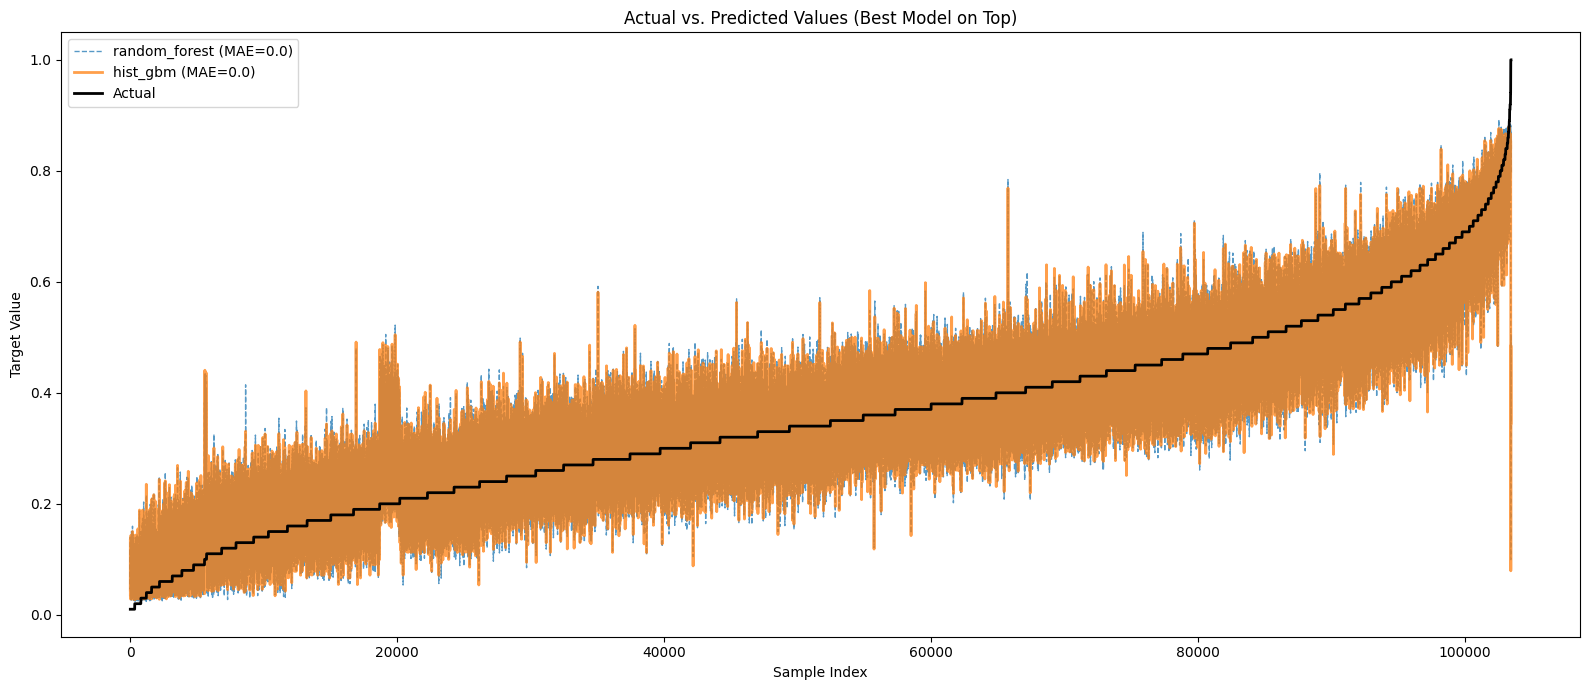

In [75]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# df_compare_sorted already defined as above
# preds already contains your model predictions

# Combine all predictions into a DataFrame for easy plotting
df_compare = pd.DataFrame({'Actual': y_test})
for name in preds:
    df_compare[name] = preds[name]

# Reset index to make charts cleaner
df_compare_sorted = df_compare.sort_values('Actual').reset_index(drop=True)

# 1. Calculate the MAE for each model
mae_scores = {}
for name in preds:
    mae_scores[name] = np.mean(np.abs(df_compare_sorted['Actual'] - df_compare_sorted[name]))

# 2. Sort models by MAE, lowest error LAST so it is plotted on top!
ordered_models = sorted(mae_scores.keys(), key=lambda k: mae_scores[k], reverse=True)

plt.figure(figsize=(16, 7))

# Plot actual values first (choose linewidth and style for clarity)

# Plot model predictions in order (lowest error will be plotted last, hence on top)
for name in ordered_models:
    plt.plot(
        df_compare_sorted[name],
        label=f"{name} (MAE={mae_scores[name]:.1f})",
        linewidth=2 if mae_scores[name] == min(mae_scores.values()) else 1,
        linestyle='-' if mae_scores[name] == min(mae_scores.values()) else '--',
        alpha=0.75
    )
    
plt.plot(df_compare_sorted['Actual'], label='Actual', linewidth=2, color='black')

plt.legend()
plt.title('Actual vs. Predicted Values (Best Model on Top)')
plt.xlabel('Sample Index')
plt.ylabel('Target Value')
plt.tight_layout()
plt.show()

array([[<Axes: title={'center': 'Actual'}>,
        <Axes: title={'center': 'random_forest'}>],
       [<Axes: title={'center': 'hist_gbm'}>, <Axes: >]], dtype=object)

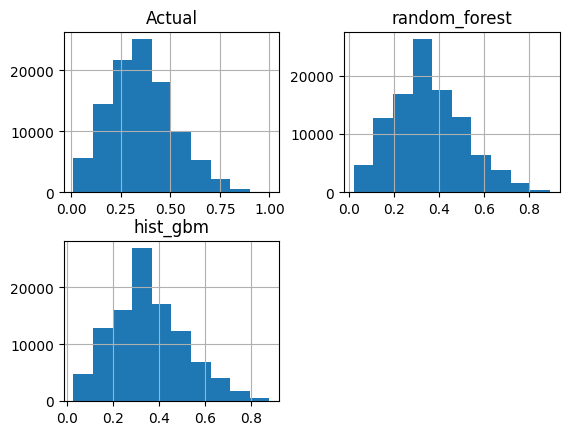

In [76]:
df_compare.hist()

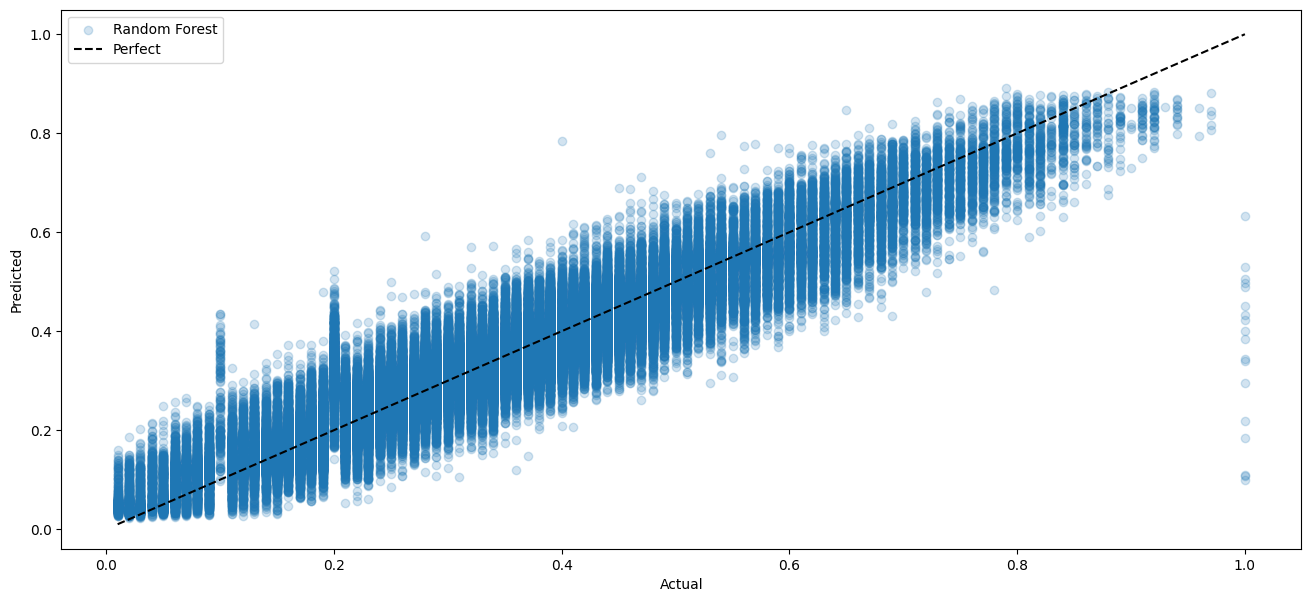

In [77]:
plt.figure(figsize=(16, 7))
plt.scatter(y_test, preds['random_forest'], alpha=0.2, label='Random Forest')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', label='Perfect')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.legend()
plt.show()

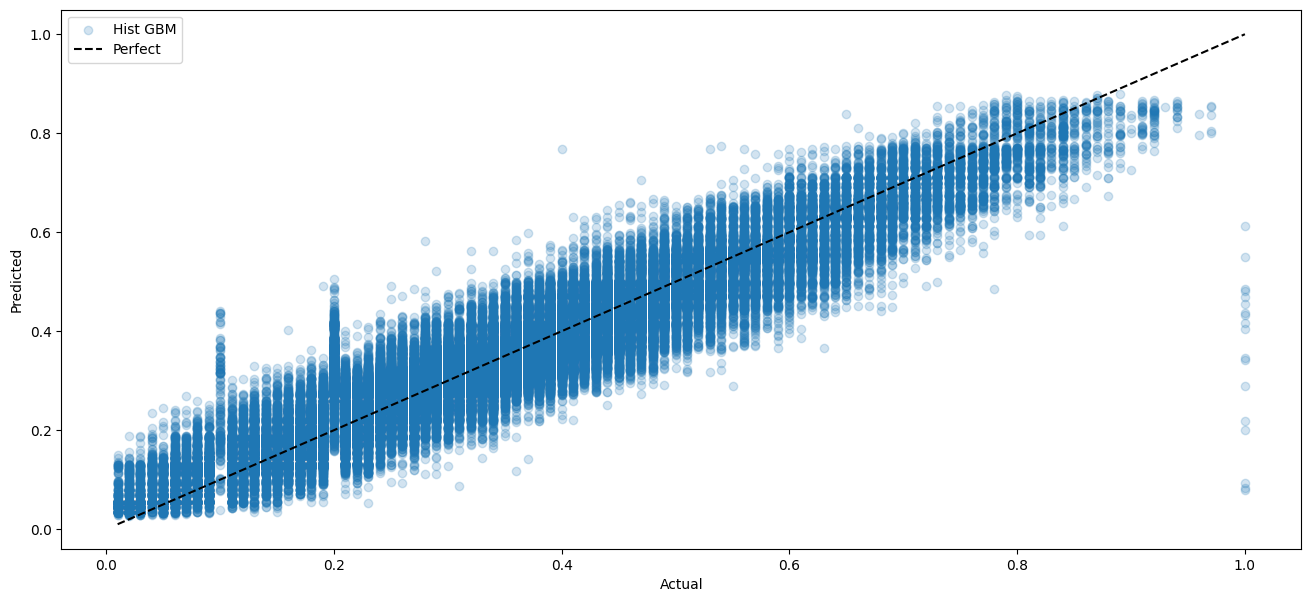

In [78]:
plt.figure(figsize=(16, 7))
plt.scatter(y_test, preds['hist_gbm'], alpha=0.2, label='Hist GBM')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', label='Perfect')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.legend()
plt.show()

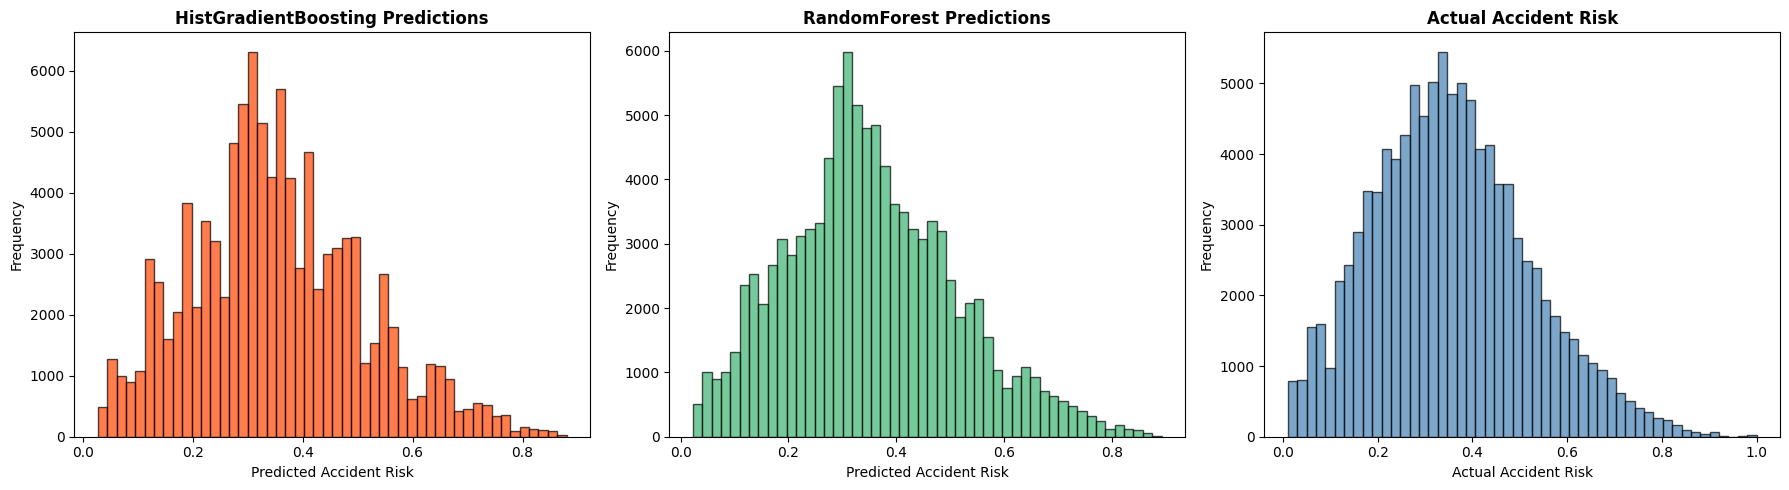

Target Variable and Prediction Statistics:
count    517144.000000
mean          0.352793
std           0.166075
min           0.010000
25%           0.230000
50%           0.340000
75%           0.460000
max           1.000000
Name: accident_risk, dtype: float64


In [79]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Histogram for HistGradientBoosting predictions
axes[0].hist(preds['hist_gbm'], bins=50, edgecolor='black', alpha=0.7, color='orangered')
axes[0].set_title('HistGradientBoosting Predictions', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Predicted Accident Risk')
axes[0].set_ylabel('Frequency')

# Histogram for RandomForest predictions
axes[1].hist(preds['random_forest'], bins=50, edgecolor='black', alpha=0.7, color='mediumseagreen')
axes[1].set_title('RandomForest Predictions', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Predicted Accident Risk')
axes[1].set_ylabel('Frequency')

# Histogram for actual values
axes[2].hist(y_test, bins=50, edgecolor='black', alpha=0.7, color='steelblue')
axes[2].set_title('Actual Accident Risk', fontsize=12, fontweight='bold')
axes[2].set_xlabel('Actual Accident Risk')
axes[2].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

print('Target Variable and Prediction Statistics:')
print(df['accident_risk'].describe())
